In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 500
EPISODES_TEST = int(EPISODES/2)
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 32
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001
epsilons_attacks = [0,0.02,0.05,0.08,0.10,0.14,0.18,0.22]


FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [25]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state.clone().detach().numpy()
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_.clone().detach().numpy()
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation, eps_greedy=True):
        if eps_greedy and random.random() < self.exploration_rate:
            return env.action_space.sample(), 0.0

        state = observation
        state = state.to(DEVICE)
        state = state.unsqueeze(0)

        q_values = self.network(state)
        return torch.argmax(q_values).item(), q_values

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)
        states.requires_grad = True
        
        q_values = self.network(states)
        next_q_values = self.network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0].detach()
        
        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)        
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

## Training the network (only run if wanting to train again)

In [26]:
agent_clean = DQN_Solver()
agent_clean.network.train()

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

for i in range(1, EPISODES):
    state = env.reset()
    score = 0

    while True:
        action, q_values = agent_clean.choose_action(state)
        
        state_, reward, done, info = env.step(action)
        agent_clean.memory.add(state, action, reward, state_, done)
        agent_clean.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent_clean.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)


/tmp/ipykernel_229/1353702249.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 29.0 Best Reward 29.0 Last Reward 29.0 Epsilon 1.0
Episode 2 Average Reward 31.5 Best Reward 34.0 Last Reward 34.0 Epsilon 0.9684910757595269
Episode 3 Average Reward 32.666666666666664 Best Reward 35.0 Last Reward 35.0 Epsilon 0.9351638519212846
Episode 4 Average Reward 29.5 Best Reward 35.0 Last Reward 20.0 Epsilon 0.9166371944443392
Episode 5 Average Reward 26.0 Best Reward 35.0 Last Reward 12.0 Epsilon 0.9056978449586682
Episode 6 Average Reward 25.166666666666668 Best Reward 35.0 Last Reward 21.0 Epsilon 0.8868671875860644
Episode 7 Average Reward 23.428571428571427 Best Reward 35.0 Last Reward 13.0 Epsilon 0.8754068367770318
Episode 8 Average Reward 22.625 Best Reward 35.0 Last Reward 17.0 Epsilon 0.8606433826830369
Episode 9 Average Reward 21.11111111111111 Best Reward 35.0 Last Reward 9.0 Epsilon 0.8529285032149548
Episode 10 Average Reward 20.3 Best Reward 35.0 Last Reward 13.0 Epsilon 0.8419067177676068
Episode 11 Average Reward 19.818181818181817 Bes

Episode 83 Average Reward 155.4578313253012 Best Reward 500.0 Last Reward 324.0 Epsilon 0.001
Episode 84 Average Reward 157.47619047619048 Best Reward 500.0 Last Reward 325.0 Epsilon 0.001
Episode 85 Average Reward 159.11764705882354 Best Reward 500.0 Last Reward 297.0 Epsilon 0.001
Episode 86 Average Reward 160.32558139534885 Best Reward 500.0 Last Reward 263.0 Epsilon 0.001
Episode 87 Average Reward 163.16091954022988 Best Reward 500.0 Last Reward 407.0 Epsilon 0.001
Episode 88 Average Reward 164.51136363636363 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 89 Average Reward 165.7078651685393 Best Reward 500.0 Last Reward 271.0 Epsilon 0.001
Episode 90 Average Reward 167.23333333333332 Best Reward 500.0 Last Reward 303.0 Epsilon 0.001
Episode 91 Average Reward 168.7912087912088 Best Reward 500.0 Last Reward 309.0 Epsilon 0.001
Episode 92 Average Reward 170.30434782608697 Best Reward 500.0 Last Reward 308.0 Epsilon 0.001
Episode 93 Average Reward 171.69892473118279 Best Rew

Episode 170 Average Reward 221.87058823529412 Best Reward 500.0 Last Reward 380.0 Epsilon 0.001
Episode 171 Average Reward 222.22222222222223 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 172 Average Reward 222.33139534883722 Best Reward 500.0 Last Reward 241.0 Epsilon 0.001
Episode 173 Average Reward 222.53757225433526 Best Reward 500.0 Last Reward 258.0 Epsilon 0.001
Episode 174 Average Reward 222.7528735632184 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 175 Average Reward 223.05142857142857 Best Reward 500.0 Last Reward 275.0 Epsilon 0.001
Episode 176 Average Reward 223.5965909090909 Best Reward 500.0 Last Reward 319.0 Epsilon 0.001
Episode 177 Average Reward 223.89265536723164 Best Reward 500.0 Last Reward 276.0 Epsilon 0.001
Episode 178 Average Reward 224.32584269662922 Best Reward 500.0 Last Reward 301.0 Epsilon 0.001
Episode 179 Average Reward 224.68156424581005 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 180 Average Reward 225.28888888888

Episode 257 Average Reward 232.3579766536965 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 258 Average Reward 232.0 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 259 Average Reward 231.95366795366795 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 260 Average Reward 232.42307692307693 Best Reward 500.0 Last Reward 354.0 Epsilon 0.001
Episode 261 Average Reward 232.02681992337165 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 262 Average Reward 232.293893129771 Best Reward 500.0 Last Reward 302.0 Epsilon 0.001
Episode 263 Average Reward 232.67300380228136 Best Reward 500.0 Last Reward 332.0 Epsilon 0.001
Episode 264 Average Reward 232.34469696969697 Best Reward 500.0 Last Reward 146.0 Epsilon 0.001
Episode 265 Average Reward 231.9056603773585 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 266 Average Reward 231.48496240601503 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 267 Average Reward 231.0823970037453 Best Reward 

Episode 343 Average Reward 211.64723032069972 Best Reward 500.0 Last Reward 197.0 Epsilon 0.001
Episode 344 Average Reward 212.17151162790697 Best Reward 500.0 Last Reward 392.0 Epsilon 0.001
Episode 345 Average Reward 212.42028985507247 Best Reward 500.0 Last Reward 298.0 Epsilon 0.001
Episode 346 Average Reward 212.35260115606937 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 347 Average Reward 212.0864553314121 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 348 Average Reward 211.98563218390805 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 349 Average Reward 211.89111747851004 Best Reward 500.0 Last Reward 179.0 Epsilon 0.001
Episode 350 Average Reward 211.83714285714285 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 351 Average Reward 211.62962962962962 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 352 Average Reward 211.4346590909091 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 353 Average Reward 211.24645892351

Episode 432 Average Reward 211.62037037037038 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 433 Average Reward 211.18013856812934 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 434 Average Reward 210.72119815668202 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 435 Average Reward 210.25977011494254 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 436 Average Reward 209.80504587155963 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 437 Average Reward 209.3432494279176 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 438 Average Reward 208.8835616438356 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 439 Average Reward 208.43052391799546 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 440 Average Reward 207.97727272727272 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 441 Average Reward 207.52607709750566 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 442 Average Reward 207.07692307692307 Best Rewa

In [27]:
#Saving the model 
#ONLY RUN WHEN TRAINED AGAIN
torch.save(agent_clean, "clean_trained_DQN.pth")

## Testing the network

In [33]:
def attack_FGSM(state, epsilon, agent):
    state.requires_grad_()
    q_values = agent.network(state.to(DEVICE))
    index_worst_case = torch.argmin(q_values)
    loss_softmax = -torch.log(torch.softmax(q_values,0)[index_worst_case])
    gradient_sign = torch.autograd.grad(loss_softmax,state,retain_graph=True)[0].sign()
    pert_state = state - gradient_sign * epsilon
    return pert_state.detach()


In [54]:
def test_network(agent):
    agent.network.eval()
    
    best_reward = 0

    episode_number = []
    average_reward_number_attacked = []

    for epsilon in epsilons_attacks:
        average_reward_attacked = 0
        print("NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS:", epsilon)
        for i in range(1,EPISODES_TEST):
            state = env.reset()
            score = 0
            while True:
                pert_state = attack_FGSM(state, epsilon, agent)
                action, q_values = agent.choose_action(pert_state,eps_greedy= False)
                state_, reward, done, info = env.step(action)

                state = state_.detach()
                score += reward

                if done:            
                    if score > best_reward:
                        best_reward = score
                    average_reward_attacked += score
                    print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward_attacked/i, best_reward, score, agent.returning_epsilon()))
                    break

                episode_number.append(i)

        average_reward_number_attacked.append(average_reward_attacked / i)
    return average_reward_number_attacked
    

In [35]:
agent_clean = torch.load("clean_trained_DQN.pth")
average_reward_number_attacked = test_network(agent_clean)

NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 237.0 Best Reward 237.0 Last Reward 237.0 Epsilon 0.001
Episode 2 Average Reward 273.0 Best Reward 309.0 Last Reward 309.0 Epsilon 0.001
Episode 3 Average Reward 271.3333333333333 Best Reward 309.0 Last Reward 268.0 Epsilon 0.001
Episode 4 Average Reward 266.75 Best Reward 309.0 Last Reward 253.0 Epsilon 0.001
Episode 5 Average Reward 273.6 Best Reward 309.0 Last Reward 301.0 Epsilon 0.001
Episode 6 Average Reward 270.0 Best Reward 309.0 Last Reward 252.0 Epsilon 0.001
Episode 7 Average Reward 273.7142857142857 Best Reward 309.0 Last Reward 296.0 Epsilon 0.001
Episode 8 Average Reward 299.5 Best Reward 480.0 Last Reward 480.0 Epsilon 0.001
Episode 9 Average Reward 303.3333333333333 Best Reward 480.0 Last Reward 334.0 Epsilon 0.001
Episode 10 Average Reward 299.9 Best Reward 480.0 Last Reward 269.0 Epsilon 0.001
Episode 11 Average Reward 294.72727272727275 Best Reward 480.0 Last Reward 243.0 Epsilon 0.001
Episode 12

Episode 90 Average Reward 315.9555555555556 Best Reward 500.0 Last Reward 290.0 Epsilon 0.001
Episode 91 Average Reward 315.5934065934066 Best Reward 500.0 Last Reward 283.0 Epsilon 0.001
Episode 92 Average Reward 317.5978260869565 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 93 Average Reward 317.18279569892474 Best Reward 500.0 Last Reward 279.0 Epsilon 0.001
Episode 94 Average Reward 317.21276595744683 Best Reward 500.0 Last Reward 320.0 Epsilon 0.001
Episode 95 Average Reward 316.6736842105263 Best Reward 500.0 Last Reward 266.0 Epsilon 0.001
Episode 96 Average Reward 316.0729166666667 Best Reward 500.0 Last Reward 259.0 Epsilon 0.001
Episode 97 Average Reward 315.97938144329896 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 98 Average Reward 317.85714285714283 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 99 Average Reward 317.3333333333333 Best Reward 500.0 Last Reward 266.0 Epsilon 0.001
Episode 100 Average Reward 317.2 Best Reward 500.0 Last 

Episode 177 Average Reward 319.61581920903956 Best Reward 500.0 Last Reward 363.0 Epsilon 0.001
Episode 178 Average Reward 319.4831460674157 Best Reward 500.0 Last Reward 296.0 Epsilon 0.001
Episode 179 Average Reward 318.9888268156425 Best Reward 500.0 Last Reward 231.0 Epsilon 0.001
Episode 180 Average Reward 319.3333333333333 Best Reward 500.0 Last Reward 381.0 Epsilon 0.001
Episode 181 Average Reward 319.6574585635359 Best Reward 500.0 Last Reward 378.0 Epsilon 0.001
Episode 182 Average Reward 319.7857142857143 Best Reward 500.0 Last Reward 343.0 Epsilon 0.001
Episode 183 Average Reward 319.39890710382514 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 184 Average Reward 319.2771739130435 Best Reward 500.0 Last Reward 297.0 Epsilon 0.001
Episode 185 Average Reward 319.07027027027027 Best Reward 500.0 Last Reward 281.0 Epsilon 0.001
Episode 186 Average Reward 319.33870967741933 Best Reward 500.0 Last Reward 369.0 Epsilon 0.001
Episode 187 Average Reward 318.88235294117646 

Episode 15 Average Reward 283.8 Best Reward 500.0 Last Reward 214.0 Epsilon 0.001
Episode 16 Average Reward 281.0625 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 17 Average Reward 286.2352941176471 Best Reward 500.0 Last Reward 369.0 Epsilon 0.001
Episode 18 Average Reward 288.94444444444446 Best Reward 500.0 Last Reward 335.0 Epsilon 0.001
Episode 19 Average Reward 287.2631578947368 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 20 Average Reward 287.0 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 21 Average Reward 287.14285714285717 Best Reward 500.0 Last Reward 290.0 Epsilon 0.001
Episode 22 Average Reward 291.45454545454544 Best Reward 500.0 Last Reward 382.0 Epsilon 0.001
Episode 23 Average Reward 288.8695652173913 Best Reward 500.0 Last Reward 232.0 Epsilon 0.001
Episode 24 Average Reward 289.8333333333333 Best Reward 500.0 Last Reward 312.0 Epsilon 0.001
Episode 25 Average Reward 291.88 Best Reward 500.0 Last Reward 341.0 Epsilon 0.001
Episode

Episode 104 Average Reward 280.5480769230769 Best Reward 500.0 Last Reward 302.0 Epsilon 0.001
Episode 105 Average Reward 282.6380952380952 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 106 Average Reward 282.3867924528302 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 107 Average Reward 282.1775700934579 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 108 Average Reward 282.712962962963 Best Reward 500.0 Last Reward 340.0 Epsilon 0.001
Episode 109 Average Reward 282.44954128440367 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 110 Average Reward 282.46363636363634 Best Reward 500.0 Last Reward 284.0 Epsilon 0.001
Episode 111 Average Reward 283.7477477477477 Best Reward 500.0 Last Reward 425.0 Epsilon 0.001
Episode 112 Average Reward 283.7142857142857 Best Reward 500.0 Last Reward 280.0 Epsilon 0.001
Episode 113 Average Reward 284.3185840707965 Best Reward 500.0 Last Reward 352.0 Epsilon 0.001
Episode 114 Average Reward 284.03508771929825 Bes

Episode 191 Average Reward 289.13612565445027 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 192 Average Reward 288.8229166666667 Best Reward 500.0 Last Reward 229.0 Epsilon 0.001
Episode 193 Average Reward 288.83937823834196 Best Reward 500.0 Last Reward 292.0 Epsilon 0.001
Episode 194 Average Reward 288.8814432989691 Best Reward 500.0 Last Reward 297.0 Epsilon 0.001
Episode 195 Average Reward 289.174358974359 Best Reward 500.0 Last Reward 346.0 Epsilon 0.001
Episode 196 Average Reward 289.3112244897959 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 197 Average Reward 289.26395939086296 Best Reward 500.0 Last Reward 280.0 Epsilon 0.001
Episode 198 Average Reward 289.050505050505 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 199 Average Reward 288.8040201005025 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 200 Average Reward 288.755 Best Reward 500.0 Last Reward 279.0 Epsilon 0.001
Episode 201 Average Reward 288.97512437810946 Best Reward 5

Episode 30 Average Reward 131.03333333333333 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 31 Average Reward 131.5483870967742 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 32 Average Reward 131.9375 Best Reward 500.0 Last Reward 144.0 Epsilon 0.001
Episode 33 Average Reward 131.24242424242425 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 34 Average Reward 130.2941176470588 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 35 Average Reward 129.94285714285715 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 36 Average Reward 129.75 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 37 Average Reward 129.0 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 38 Average Reward 128.28947368421052 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 39 Average Reward 128.17948717948718 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 40 Average Reward 127.8 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episod

Episode 120 Average Reward 125.65 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 121 Average Reward 125.57851239669421 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 122 Average Reward 125.40163934426229 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 123 Average Reward 125.4959349593496 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 124 Average Reward 125.68548387096774 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 125 Average Reward 125.64 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 126 Average Reward 125.63492063492063 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 127 Average Reward 125.48031496062993 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 128 Average Reward 125.546875 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 129 Average Reward 125.28682170542636 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 130 Average Reward 125.11538461538461 Best Reward 500.0 Last Reward

Episode 207 Average Reward 125.56038647342996 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 208 Average Reward 125.41826923076923 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 209 Average Reward 125.29186602870813 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 210 Average Reward 125.24285714285715 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 211 Average Reward 125.13270142180095 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 212 Average Reward 125.19339622641509 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 213 Average Reward 125.19718309859155 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 214 Average Reward 125.07943925233644 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 215 Average Reward 125.14883720930233 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 216 Average Reward 125.27777777777777 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 217 Average Reward 125.27649769585

Episode 47 Average Reward 68.57446808510639 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 48 Average Reward 68.27083333333333 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 49 Average Reward 67.93877551020408 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 50 Average Reward 67.6 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 51 Average Reward 67.19607843137256 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 52 Average Reward 66.88461538461539 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 53 Average Reward 67.50943396226415 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 54 Average Reward 67.22222222222223 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 55 Average Reward 66.83636363636364 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 56 Average Reward 66.44642857142857 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 57 Average Reward 66.17543859649123 Best Reward 500.0 Last Reward 51.0 Eps

Episode 136 Average Reward 68.68382352941177 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 137 Average Reward 68.89781021897811 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 138 Average Reward 68.79710144927536 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 139 Average Reward 69.02158273381295 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 140 Average Reward 69.22857142857143 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 141 Average Reward 69.38297872340425 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 142 Average Reward 69.59154929577464 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 143 Average Reward 69.47552447552448 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 144 Average Reward 69.65972222222223 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 145 Average Reward 69.88275862068966 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 146 Average Reward 70.06164383561644 Best Reward 5

Episode 226 Average Reward 71.97345132743362 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 227 Average Reward 72.07929515418502 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 228 Average Reward 72.01315789473684 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 229 Average Reward 71.8995633187773 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 230 Average Reward 72.00869565217391 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 231 Average Reward 71.91341991341992 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 232 Average Reward 71.83189655172414 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 233 Average Reward 71.93562231759657 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 234 Average Reward 72.02991452991454 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 235 Average Reward 71.9531914893617 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 236 Average Reward 72.04661016949153 Best Reward 500.0

Episode 68 Average Reward 61.61764705882353 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 69 Average Reward 61.89855072463768 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 70 Average Reward 61.6 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 71 Average Reward 61.87323943661972 Best Reward 500.0 Last Reward 81.0 Epsilon 0.001
Episode 72 Average Reward 61.541666666666664 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 73 Average Reward 61.19178082191781 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 74 Average Reward 60.945945945945944 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 75 Average Reward 60.68 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 76 Average Reward 60.96052631578947 Best Reward 500.0 Last Reward 82.0 Epsilon 0.001
Episode 77 Average Reward 60.62337662337662 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 78 Average Reward 60.833333333333336 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001

Episode 158 Average Reward 59.063291139240505 Best Reward 500.0 Last Reward 79.0 Epsilon 0.001
Episode 159 Average Reward 58.937106918238996 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 160 Average Reward 58.8125 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 161 Average Reward 58.68944099378882 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 162 Average Reward 58.574074074074076 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 163 Average Reward 58.7239263803681 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 164 Average Reward 58.61585365853659 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 165 Average Reward 58.763636363636365 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 166 Average Reward 58.6566265060241 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 167 Average Reward 58.550898203592816 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 168 Average Reward 58.43452380952381 Best Reward 500.0 Last

Episode 246 Average Reward 58.447154471544714 Best Reward 500.0 Last Reward 82.0 Epsilon 0.001
Episode 247 Average Reward 58.54655870445344 Best Reward 500.0 Last Reward 83.0 Epsilon 0.001
Episode 248 Average Reward 58.483870967741936 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 249 Average Reward 58.42168674698795 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.14
Episode 1 Average Reward 54.0 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 2 Average Reward 40.0 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 3 Average Reward 46.333333333333336 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 4 Average Reward 41.5 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 5 Average Reward 38.2 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 6 Average Reward 36.166666666666664 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 7 Average Reward 34.57142857142857 Best Reward 500.0 Last Rewa

Episode 88 Average Reward 39.98863636363637 Best Reward 500.0 Last Reward 61.0 Epsilon 0.001
Episode 89 Average Reward 40.20224719101124 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 90 Average Reward 40.06666666666667 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 91 Average Reward 39.9010989010989 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 92 Average Reward 39.71739130434783 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 93 Average Reward 39.53763440860215 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 94 Average Reward 39.765957446808514 Best Reward 500.0 Last Reward 61.0 Epsilon 0.001
Episode 95 Average Reward 39.93684210526316 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 96 Average Reward 40.072916666666664 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 97 Average Reward 40.24742268041237 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 98 Average Reward 40.11224489795919 Best Reward 500.0 Last Re

Episode 178 Average Reward 41.140449438202246 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 179 Average Reward 41.039106145251395 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 180 Average Reward 41.12777777777778 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 181 Average Reward 41.20441988950276 Best Reward 500.0 Last Reward 55.0 Epsilon 0.001
Episode 182 Average Reward 41.13186813186813 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 183 Average Reward 41.05464480874317 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 184 Average Reward 40.97826086956522 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 185 Average Reward 41.064864864864866 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 186 Average Reward 41.16129032258065 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 187 Average Reward 41.0855614973262 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 188 Average Reward 41.0 Best Reward 500.0 Last Rew

Episode 21 Average Reward 14.380952380952381 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 22 Average Reward 14.454545454545455 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 23 Average Reward 14.521739130434783 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 24 Average Reward 14.458333333333334 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 25 Average Reward 14.48 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 26 Average Reward 14.615384615384615 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 27 Average Reward 14.74074074074074 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 28 Average Reward 14.964285714285714 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 29 Average Reward 14.89655172413793 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 30 Average Reward 14.9 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 31 Average Reward 14.935483870967742 Best Reward 500.0 Last Reward 16.0 Epsilon 0

Episode 112 Average Reward 14.821428571428571 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 113 Average Reward 14.814159292035399 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 114 Average Reward 14.807017543859649 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 115 Average Reward 14.826086956521738 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 116 Average Reward 14.810344827586206 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 117 Average Reward 14.777777777777779 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 118 Average Reward 14.779661016949152 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 119 Average Reward 14.764705882352942 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 120 Average Reward 14.783333333333333 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 121 Average Reward 14.793388429752065 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 122 Average Reward 14.770491803278688 Best

Episode 205 Average Reward 14.863414634146341 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 206 Average Reward 14.868932038834952 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 207 Average Reward 14.859903381642512 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 208 Average Reward 14.875 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 209 Average Reward 14.875598086124402 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 210 Average Reward 14.876190476190477 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 211 Average Reward 14.872037914691942 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 212 Average Reward 14.867924528301886 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 213 Average Reward 14.868544600938968 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 214 Average Reward 14.873831775700934 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 215 Average Reward 14.874418604651163 Best Reward 500.

Episode 47 Average Reward 11.702127659574469 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 48 Average Reward 11.6875 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 49 Average Reward 11.673469387755102 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 50 Average Reward 11.64 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 51 Average Reward 11.627450980392156 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 52 Average Reward 11.615384615384615 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 53 Average Reward 11.622641509433961 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 54 Average Reward 11.592592592592593 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 55 Average Reward 11.581818181818182 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 56 Average Reward 11.571428571428571 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 57 Average Reward 11.614035087719298 Best Reward 500.0 Last Reward 14.0 Epsi

Episode 137 Average Reward 11.620437956204379 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 138 Average Reward 11.623188405797102 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 139 Average Reward 11.633093525179856 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 140 Average Reward 11.635714285714286 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 141 Average Reward 11.638297872340425 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 142 Average Reward 11.633802816901408 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 143 Average Reward 11.636363636363637 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 144 Average Reward 11.631944444444445 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 145 Average Reward 11.627586206896552 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 146 Average Reward 11.63013698630137 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 147 Average Reward 11.625850340136054 Best 

Episode 225 Average Reward 11.626666666666667 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 226 Average Reward 11.619469026548673 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 227 Average Reward 11.616740088105727 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 228 Average Reward 11.609649122807017 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 229 Average Reward 11.606986899563319 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 230 Average Reward 11.604347826086956 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 231 Average Reward 11.601731601731602 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 232 Average Reward 11.60344827586207 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 233 Average Reward 11.605150214592275 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 234 Average Reward 11.602564102564102 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 235 Average Reward 11.604255319148937 Best 

# Plotting

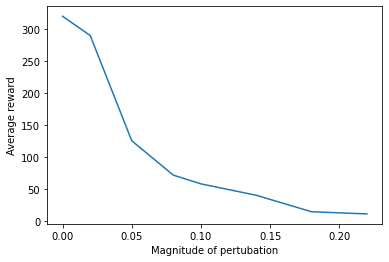

In [36]:
plt.figure(1)
plt.plot(epsilons_attacks,average_reward_number_attacked)
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.show()

## Training with adversarial training (only run if you want to train again)

In [59]:
def train_robust(agent_robust, EPSILON_PERT):
    agent_robust.network.train()

    best_reward = 0
    average_reward = 0
    episode_number = []
    average_reward_number = []


    for i in range(1, EPISODES):
        epsilon_pertubated = EPSILON_PERT/(EPISODES - i)
        state = env.reset()
        score = 0
        while True:
            pert_state = attack_FGSM(state, epsilon_pertubated, agent_robust)
            action, q_values = agent_robust.choose_action(pert_state)
            state_, reward, done, info = env.step(action)


            agent_robust.memory.add(state, action, reward, state_, done)
            agent_robust.learn()
            state = state_
            score += reward

            if done:
                if score > best_reward:
                    best_reward = score
                average_reward += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
                break

            episode_number.append(i)
            average_reward_number.append(average_reward/i)

In [60]:
robust_agent_1 = DQN_Solver()
robust_agent_2 = DQN_Solver()
robust_agent_3 = DQN_Solver()
robust_agent_4 = DQN_Solver()

agents = [[robust_agent_1,epsilons_attacks[1]],[robust_agent_2, epsilons_attacks[2]], [robust_agent_3, epsilons_attacks[3]], [robust_agent_4, epsilons_attacks[4]]]
for agent, eps in agents:
    print("NOW TRAINING AGENT WITH EPS:", eps)
    train_robust(agent, eps)

/tmp/ipykernel_229/1353702249.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


NOW TRAINING AGENT WITH EPS: 0.02
Episode 1 Average Reward 11.0 Best Reward 11.0 Last Reward 11.0 Epsilon 1.0
Episode 2 Average Reward 13.5 Best Reward 16.0 Last Reward 16.0 Epsilon 1.0
Episode 3 Average Reward 16.666666666666668 Best Reward 23.0 Last Reward 23.0 Epsilon 0.9811700348643991
Episode 4 Average Reward 16.75 Best Reward 23.0 Last Reward 17.0 Epsilon 0.9646229185299474
Episode 5 Average Reward 17.4 Best Reward 23.0 Last Reward 20.0 Epsilon 0.9455126435024219
Episode 6 Average Reward 18.5 Best Reward 24.0 Last Reward 24.0 Epsilon 0.9230793978373364
Episode 7 Average Reward 17.428571428571427 Best Reward 24.0 Last Reward 11.0 Epsilon 0.9129761418240965
Episode 8 Average Reward 17.125 Best Reward 24.0 Last Reward 15.0 Epsilon 0.8993769480309576
Episode 9 Average Reward 17.333333333333332 Best Reward 24.0 Last Reward 19.0 Epsilon 0.8824417114557717
Episode 10 Average Reward 19.1 Best Reward 35.0 Last Reward 35.0 Epsilon 0.8520755747117399
Episode 11 Average Reward 18.72727272727

Episode 82 Average Reward 145.890243902439 Best Reward 500.0 Last Reward 268.0 Epsilon 0.001
Episode 83 Average Reward 149.0722891566265 Best Reward 500.0 Last Reward 410.0 Epsilon 0.001
Episode 84 Average Reward 150.07142857142858 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 85 Average Reward 152.03529411764706 Best Reward 500.0 Last Reward 317.0 Epsilon 0.001
Episode 86 Average Reward 153.2674418604651 Best Reward 500.0 Last Reward 258.0 Epsilon 0.001
Episode 87 Average Reward 157.2528735632184 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 88 Average Reward 158.4659090909091 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 89 Average Reward 161.25842696629215 Best Reward 500.0 Last Reward 407.0 Epsilon 0.001
Episode 90 Average Reward 163.83333333333334 Best Reward 500.0 Last Reward 393.0 Epsilon 0.001
Episode 91 Average Reward 166.32967032967034 Best Reward 500.0 Last Reward 391.0 Epsilon 0.001
Episode 92 Average Reward 167.3586956521739 Best Reward 

Episode 169 Average Reward 220.15384615384616 Best Reward 500.0 Last Reward 262.0 Epsilon 0.001
Episode 170 Average Reward 220.21176470588236 Best Reward 500.0 Last Reward 230.0 Epsilon 0.001
Episode 171 Average Reward 220.76608187134502 Best Reward 500.0 Last Reward 315.0 Epsilon 0.001
Episode 172 Average Reward 221.15116279069767 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 173 Average Reward 221.635838150289 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 174 Average Reward 221.86206896551724 Best Reward 500.0 Last Reward 261.0 Epsilon 0.001
Episode 175 Average Reward 222.06285714285715 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 176 Average Reward 222.03977272727272 Best Reward 500.0 Last Reward 218.0 Epsilon 0.001
Episode 177 Average Reward 222.61016949152543 Best Reward 500.0 Last Reward 323.0 Epsilon 0.001
Episode 178 Average Reward 222.65168539325842 Best Reward 500.0 Last Reward 230.0 Epsilon 0.001
Episode 179 Average Reward 222.70949720670

Episode 255 Average Reward 227.9764705882353 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 256 Average Reward 228.1171875 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 257 Average Reward 227.94163424124514 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 258 Average Reward 227.86434108527132 Best Reward 500.0 Last Reward 208.0 Epsilon 0.001
Episode 259 Average Reward 227.8069498069498 Best Reward 500.0 Last Reward 213.0 Epsilon 0.001
Episode 260 Average Reward 227.66538461538462 Best Reward 500.0 Last Reward 191.0 Epsilon 0.001
Episode 261 Average Reward 228.17241379310346 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 262 Average Reward 228.0381679389313 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 263 Average Reward 227.84410646387832 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 264 Average Reward 227.7651515151515 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 265 Average Reward 227.7056603773585 Best R

Episode 342 Average Reward 226.03216374269005 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 343 Average Reward 226.01457725947523 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 344 Average Reward 225.9127906976744 Best Reward 500.0 Last Reward 191.0 Epsilon 0.001
Episode 345 Average Reward 225.85507246376812 Best Reward 500.0 Last Reward 206.0 Epsilon 0.001
Episode 346 Average Reward 225.91907514450867 Best Reward 500.0 Last Reward 248.0 Epsilon 0.001
Episode 347 Average Reward 225.7492795389049 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 348 Average Reward 225.5632183908046 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 349 Average Reward 225.64469914040114 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 350 Average Reward 225.54285714285714 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 351 Average Reward 225.3846153846154 Best Reward 500.0 Last Reward 170.0 Epsilon 0.001
Episode 352 Average Reward 225.2698863636363

Episode 428 Average Reward 222.30140186915887 Best Reward 500.0 Last Reward 235.0 Epsilon 0.001
Episode 429 Average Reward 222.1818181818182 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 430 Average Reward 222.13023255813954 Best Reward 500.0 Last Reward 200.0 Epsilon 0.001
Episode 431 Average Reward 222.07192575406032 Best Reward 500.0 Last Reward 197.0 Epsilon 0.001
Episode 432 Average Reward 221.96296296296296 Best Reward 500.0 Last Reward 175.0 Epsilon 0.001
Episode 433 Average Reward 221.91685912240186 Best Reward 500.0 Last Reward 202.0 Epsilon 0.001
Episode 434 Average Reward 221.80875576036865 Best Reward 500.0 Last Reward 175.0 Epsilon 0.001
Episode 435 Average Reward 221.69655172413792 Best Reward 500.0 Last Reward 173.0 Epsilon 0.001
Episode 436 Average Reward 221.60550458715596 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 437 Average Reward 221.5537757437071 Best Reward 500.0 Last Reward 199.0 Epsilon 0.001
Episode 438 Average Reward 221.49771689497

Episode 16 Average Reward 20.375 Best Reward 40.0 Last Reward 11.0 Epsilon 0.7444217038990517
Episode 17 Average Reward 20.0 Best Reward 40.0 Last Reward 14.0 Epsilon 0.7340672721936974
Episode 18 Average Reward 20.333333333333332 Best Reward 40.0 Last Reward 26.0 Epsilon 0.7152181973314037
Episode 19 Average Reward 20.05263157894737 Best Reward 40.0 Last Reward 15.0 Epsilon 0.704564697832001
Episode 20 Average Reward 19.55 Best Reward 40.0 Last Reward 10.0 Epsilon 0.6975506718651011
Episode 21 Average Reward 19.238095238095237 Best Reward 40.0 Last Reward 13.0 Epsilon 0.6885367230816204
Episode 22 Average Reward 19.0 Best Reward 40.0 Last Reward 14.0 Epsilon 0.6789596158607596
Episode 23 Average Reward 18.782608695652176 Best Reward 40.0 Last Reward 14.0 Epsilon 0.6695157201007336
Episode 24 Average Reward 18.708333333333332 Best Reward 40.0 Last Reward 17.0 Epsilon 0.6582245533155777
Episode 25 Average Reward 18.92 Best Reward 40.0 Last Reward 24.0 Epsilon 0.6426075087326283
Episode 

Episode 99 Average Reward 207.84848484848484 Best Reward 500.0 Last Reward 322.0 Epsilon 0.001
Episode 100 Average Reward 209.95 Best Reward 500.0 Last Reward 418.0 Epsilon 0.001
Episode 101 Average Reward 211.04950495049505 Best Reward 500.0 Last Reward 321.0 Epsilon 0.001
Episode 102 Average Reward 211.98039215686273 Best Reward 500.0 Last Reward 306.0 Epsilon 0.001
Episode 103 Average Reward 213.09708737864077 Best Reward 500.0 Last Reward 327.0 Epsilon 0.001
Episode 104 Average Reward 214.40384615384616 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 105 Average Reward 215.55238095238096 Best Reward 500.0 Last Reward 335.0 Epsilon 0.001
Episode 106 Average Reward 217.06603773584905 Best Reward 500.0 Last Reward 376.0 Epsilon 0.001
Episode 107 Average Reward 219.34579439252337 Best Reward 500.0 Last Reward 461.0 Epsilon 0.001
Episode 108 Average Reward 220.5462962962963 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 109 Average Reward 222.22935779816513 Best Rew

Episode 186 Average Reward 281.64516129032256 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 187 Average Reward 282.11764705882354 Best Reward 500.0 Last Reward 370.0 Epsilon 0.001
Episode 188 Average Reward 282.0744680851064 Best Reward 500.0 Last Reward 274.0 Epsilon 0.001
Episode 189 Average Reward 283.2275132275132 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 190 Average Reward 283.33684210526314 Best Reward 500.0 Last Reward 304.0 Epsilon 0.001
Episode 191 Average Reward 283.1256544502618 Best Reward 500.0 Last Reward 243.0 Epsilon 0.001
Episode 192 Average Reward 283.6458333333333 Best Reward 500.0 Last Reward 383.0 Epsilon 0.001
Episode 193 Average Reward 283.65284974093265 Best Reward 500.0 Last Reward 285.0 Epsilon 0.001
Episode 194 Average Reward 283.2680412371134 Best Reward 500.0 Last Reward 209.0 Epsilon 0.001
Episode 195 Average Reward 282.98974358974357 Best Reward 500.0 Last Reward 229.0 Epsilon 0.001
Episode 196 Average Reward 282.7551020408163 

Episode 274 Average Reward 273.83941605839414 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 275 Average Reward 273.8545454545455 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 276 Average Reward 272.90579710144925 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 277 Average Reward 271.956678700361 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 278 Average Reward 271.01079136690646 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 279 Average Reward 270.0752688172043 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 280 Average Reward 269.14285714285717 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 281 Average Reward 268.2135231316726 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 282 Average Reward 267.29787234042556 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 283 Average Reward 266.3886925795053 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 284 Average Reward 265.4823943661972 Best Reward 

Episode 361 Average Reward 271.8393351800554 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 362 Average Reward 271.95580110497235 Best Reward 500.0 Last Reward 314.0 Epsilon 0.001
Episode 363 Average Reward 271.58677685950414 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 364 Average Reward 271.6043956043956 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 365 Average Reward 271.23835616438356 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 366 Average Reward 270.9754098360656 Best Reward 500.0 Last Reward 175.0 Epsilon 0.001
Episode 367 Average Reward 270.6239782016349 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 368 Average Reward 270.32608695652175 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 369 Average Reward 269.9539295392954 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 370 Average Reward 269.7027027027027 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 371 Average Reward 269.53099730458223 

Episode 448 Average Reward 265.5424107142857 Best Reward 500.0 Last Reward 499.0 Epsilon 0.001
Episode 449 Average Reward 266.06458797327394 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 450 Average Reward 265.58444444444444 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 451 Average Reward 265.2461197339246 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 452 Average Reward 264.80973451327435 Best Reward 500.0 Last Reward 68.0 Epsilon 0.001
Episode 453 Average Reward 264.2560706401766 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 454 Average Reward 263.69603524229075 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 455 Average Reward 263.13626373626374 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 456 Average Reward 262.57675438596493 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 457 Average Reward 262.0218818380744 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 458 Average Reward 261.4694323144105 Best Rewa

Episode 34 Average Reward 72.5 Best Reward 225.0 Last Reward 213.0 Epsilon 0.08757866929038717
Episode 35 Average Reward 74.85714285714286 Best Reward 225.0 Last Reward 155.0 Epsilon 0.07499788516467158
Episode 36 Average Reward 76.61111111111111 Best Reward 225.0 Last Reward 138.0 Epsilon 0.06532604899029316
Episode 37 Average Reward 79.10810810810811 Best Reward 225.0 Last Reward 169.0 Epsilon 0.0551637653500615
Episode 38 Average Reward 81.84210526315789 Best Reward 225.0 Last Reward 183.0 Epsilon 0.04593442113789762
Episode 39 Average Reward 84.87179487179488 Best Reward 225.0 Last Reward 200.0 Epsilon 0.03760416009731858
Episode 40 Average Reward 91.125 Best Reward 335.0 Last Reward 335.0 Epsilon 0.026895179596965687
Episode 41 Average Reward 92.8780487804878 Best Reward 335.0 Last Reward 163.0 Epsilon 0.022848044162483917
Episode 42 Average Reward 97.5 Best Reward 335.0 Last Reward 287.0 Epsilon 0.01714526296146131
Episode 43 Average Reward 99.62790697674419 Best Reward 335.0 Las

Episode 119 Average Reward 196.73949579831933 Best Reward 464.0 Last Reward 195.0 Epsilon 0.001
Episode 120 Average Reward 196.83333333333334 Best Reward 464.0 Last Reward 208.0 Epsilon 0.001
Episode 121 Average Reward 197.13223140495867 Best Reward 464.0 Last Reward 233.0 Epsilon 0.001
Episode 122 Average Reward 197.47540983606558 Best Reward 464.0 Last Reward 239.0 Epsilon 0.001
Episode 123 Average Reward 197.33333333333334 Best Reward 464.0 Last Reward 180.0 Epsilon 0.001
Episode 124 Average Reward 197.54032258064515 Best Reward 464.0 Last Reward 223.0 Epsilon 0.001
Episode 125 Average Reward 197.784 Best Reward 464.0 Last Reward 228.0 Epsilon 0.001
Episode 126 Average Reward 198.13492063492063 Best Reward 464.0 Last Reward 242.0 Epsilon 0.001
Episode 127 Average Reward 198.20472440944883 Best Reward 464.0 Last Reward 207.0 Epsilon 0.001
Episode 128 Average Reward 198.3515625 Best Reward 464.0 Last Reward 217.0 Epsilon 0.001
Episode 129 Average Reward 198.47286821705427 Best Reward 

Episode 206 Average Reward 204.33495145631068 Best Reward 464.0 Last Reward 163.0 Epsilon 0.001
Episode 207 Average Reward 204.67632850241546 Best Reward 464.0 Last Reward 275.0 Epsilon 0.001
Episode 208 Average Reward 204.40384615384616 Best Reward 464.0 Last Reward 148.0 Epsilon 0.001
Episode 209 Average Reward 204.76076555023923 Best Reward 464.0 Last Reward 279.0 Epsilon 0.001
Episode 210 Average Reward 205.16666666666666 Best Reward 464.0 Last Reward 290.0 Epsilon 0.001
Episode 211 Average Reward 204.97630331753555 Best Reward 464.0 Last Reward 165.0 Epsilon 0.001
Episode 212 Average Reward 204.68867924528303 Best Reward 464.0 Last Reward 144.0 Epsilon 0.001
Episode 213 Average Reward 204.61032863849766 Best Reward 464.0 Last Reward 188.0 Epsilon 0.001
Episode 214 Average Reward 204.53271028037383 Best Reward 464.0 Last Reward 188.0 Epsilon 0.001
Episode 215 Average Reward 205.05581395348838 Best Reward 464.0 Last Reward 317.0 Epsilon 0.001
Episode 216 Average Reward 205.134259259

Episode 293 Average Reward 209.49146757679182 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 294 Average Reward 209.33333333333334 Best Reward 500.0 Last Reward 163.0 Epsilon 0.001
Episode 295 Average Reward 209.37627118644068 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 296 Average Reward 209.52702702702703 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 297 Average Reward 209.44781144781146 Best Reward 500.0 Last Reward 186.0 Epsilon 0.001
Episode 298 Average Reward 209.54026845637583 Best Reward 500.0 Last Reward 237.0 Epsilon 0.001
Episode 299 Average Reward 210.12709030100334 Best Reward 500.0 Last Reward 385.0 Epsilon 0.001
Episode 300 Average Reward 209.98 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 301 Average Reward 209.91029900332225 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 302 Average Reward 210.08940397350995 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 303 Average Reward 210.003300330033 Best Rew

Episode 382 Average Reward 210.14921465968587 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 383 Average Reward 209.62924281984334 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 384 Average Reward 209.10416666666666 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 385 Average Reward 208.587012987013 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 386 Average Reward 208.07253886010363 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 387 Average Reward 207.5581395348837 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 388 Average Reward 207.04381443298968 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 389 Average Reward 206.53470437017995 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 390 Average Reward 206.02820512820512 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 391 Average Reward 205.5242966751918 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 392 Average Reward 205.02551020408163 Best Reward 50

Episode 469 Average Reward 215.36673773987206 Best Reward 500.0 Last Reward 198.0 Epsilon 0.001
Episode 470 Average Reward 215.53191489361703 Best Reward 500.0 Last Reward 293.0 Epsilon 0.001
Episode 471 Average Reward 215.59447983014863 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 472 Average Reward 215.5635593220339 Best Reward 500.0 Last Reward 201.0 Epsilon 0.001
Episode 473 Average Reward 215.70401691331924 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 474 Average Reward 215.71729957805908 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 475 Average Reward 215.54736842105262 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 476 Average Reward 215.58193277310923 Best Reward 500.0 Last Reward 232.0 Epsilon 0.001
Episode 477 Average Reward 215.67714884696016 Best Reward 500.0 Last Reward 261.0 Epsilon 0.001
Episode 478 Average Reward 215.8828451882845 Best Reward 500.0 Last Reward 314.0 Epsilon 0.001
Episode 479 Average Reward 215.94572025052

Episode 53 Average Reward 26.79245283018868 Best Reward 96.0 Last Reward 40.0 Epsilon 0.24915129331788444
Episode 54 Average Reward 27.37037037037037 Best Reward 96.0 Last Reward 58.0 Epsilon 0.23510478215678413
Episode 55 Average Reward 28.21818181818182 Best Reward 96.0 Last Reward 74.0 Epsilon 0.21832707263495027
Episode 56 Average Reward 28.75 Best Reward 96.0 Last Reward 58.0 Epsilon 0.2060183520110343
Episode 57 Average Reward 28.92982456140351 Best Reward 96.0 Last Reward 39.0 Epsilon 0.1981344299069931
Episode 58 Average Reward 30.379310344827587 Best Reward 113.0 Last Reward 113.0 Epsilon 0.1769538920151533
Episode 59 Average Reward 30.661016949152543 Best Reward 113.0 Last Reward 47.0 Epsilon 0.16882550823318393
Episode 60 Average Reward 32.7 Best Reward 153.0 Last Reward 153.0 Epsilon 0.14486309656989407
Episode 61 Average Reward 40.36065573770492 Best Reward 500.0 Last Reward 500.0 Epsilon 0.08784193164737629
Episode 62 Average Reward 45.064516129032256 Best Reward 500.0 La

Episode 138 Average Reward 189.8840579710145 Best Reward 500.0 Last Reward 270.0 Epsilon 0.001
Episode 139 Average Reward 190.4820143884892 Best Reward 500.0 Last Reward 273.0 Epsilon 0.001
Episode 140 Average Reward 191.18571428571428 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 141 Average Reward 191.8368794326241 Best Reward 500.0 Last Reward 283.0 Epsilon 0.001
Episode 142 Average Reward 192.25352112676057 Best Reward 500.0 Last Reward 251.0 Epsilon 0.001
Episode 143 Average Reward 192.5034965034965 Best Reward 500.0 Last Reward 228.0 Epsilon 0.001
Episode 144 Average Reward 192.92361111111111 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 145 Average Reward 193.33793103448275 Best Reward 500.0 Last Reward 253.0 Epsilon 0.001
Episode 146 Average Reward 193.82876712328766 Best Reward 500.0 Last Reward 265.0 Epsilon 0.001
Episode 147 Average Reward 194.00680272108843 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 148 Average Reward 194.0810810810811

Episode 225 Average Reward 229.95555555555555 Best Reward 500.0 Last Reward 188.0 Epsilon 0.001
Episode 226 Average Reward 229.68584070796462 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 227 Average Reward 229.53303964757708 Best Reward 500.0 Last Reward 195.0 Epsilon 0.001
Episode 228 Average Reward 229.48684210526315 Best Reward 500.0 Last Reward 219.0 Epsilon 0.001
Episode 229 Average Reward 229.19650655021834 Best Reward 500.0 Last Reward 163.0 Epsilon 0.001
Episode 230 Average Reward 229.02173913043478 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 231 Average Reward 230.14718614718615 Best Reward 500.0 Last Reward 489.0 Epsilon 0.001
Episode 232 Average Reward 230.20689655172413 Best Reward 500.0 Last Reward 244.0 Epsilon 0.001
Episode 233 Average Reward 229.42060085836908 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 234 Average Reward 229.06837606837607 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 235 Average Reward 228.4510638297

Episode 312 Average Reward 248.26923076923077 Best Reward 500.0 Last Reward 213.0 Epsilon 0.001
Episode 313 Average Reward 248.6453674121406 Best Reward 500.0 Last Reward 366.0 Epsilon 0.001
Episode 314 Average Reward 248.52866242038218 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 315 Average Reward 248.24126984126985 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 316 Average Reward 247.9873417721519 Best Reward 500.0 Last Reward 168.0 Epsilon 0.001
Episode 317 Average Reward 247.84542586750788 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 318 Average Reward 247.72955974842768 Best Reward 500.0 Last Reward 211.0 Epsilon 0.001
Episode 319 Average Reward 247.55799373040753 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 320 Average Reward 247.390625 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 321 Average Reward 247.16822429906543 Best Reward 500.0 Last Reward 176.0 Epsilon 0.001
Episode 322 Average Reward 247.04658385093168 Best

Episode 399 Average Reward 253.8045112781955 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 400 Average Reward 253.645 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 401 Average Reward 253.4638403990025 Best Reward 500.0 Last Reward 181.0 Epsilon 0.001
Episode 402 Average Reward 253.47512437810946 Best Reward 500.0 Last Reward 258.0 Epsilon 0.001
Episode 403 Average Reward 253.55086848635236 Best Reward 500.0 Last Reward 284.0 Epsilon 0.001
Episode 404 Average Reward 253.6138613861386 Best Reward 500.0 Last Reward 279.0 Epsilon 0.001
Episode 405 Average Reward 253.8469135802469 Best Reward 500.0 Last Reward 348.0 Epsilon 0.001
Episode 406 Average Reward 254.0 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 407 Average Reward 254.03439803439804 Best Reward 500.0 Last Reward 268.0 Epsilon 0.001
Episode 408 Average Reward 254.2671568627451 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 409 Average Reward 254.68948655256725 Best Reward 500.0 Last 

Episode 486 Average Reward 269.31893004115227 Best Reward 500.0 Last Reward 308.0 Epsilon 0.001
Episode 487 Average Reward 269.7618069815195 Best Reward 500.0 Last Reward 485.0 Epsilon 0.001
Episode 488 Average Reward 270.2336065573771 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 489 Average Reward 269.95910020449895 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 490 Average Reward 269.7530612244898 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 491 Average Reward 269.5865580448065 Best Reward 500.0 Last Reward 188.0 Epsilon 0.001
Episode 492 Average Reward 269.2947154471545 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 493 Average Reward 269.05679513184583 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 494 Average Reward 268.831983805668 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 495 Average Reward 268.630303030303 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 496 Average Reward 268.5100806451613 Best

In [61]:
torch.save(robust_agent_1, "robust_trained_DQN1.pth")
torch.save(robust_agent_2, "robust_trained_DQN2.pth")
torch.save(robust_agent_3, "robust_trained_DQN3.pth")
torch.save(robust_agent_4, "robust_trained_DQN4.pth")

## Testing robust network

In [62]:
robust_agent_1 = torch.load("robust_trained_DQN1.pth")
robust_agent_2 = torch.load("robust_trained_DQN2.pth")
robust_agent_3 = torch.load("robust_trained_DQN3.pth")
robust_agent_4 = torch.load("robust_trained_DQN4.pth")


In [63]:
robust_agents = [robust_agent_1, robust_agent_2,robust_agent_3,robust_agent_4]
robust_average_rewards = []
for agent in robust_agents:
    print("The current agent is", agent)
    average_rewards = test_network(agent)
    robust_average_rewards.append(average_rewards)

The current agent is <__main__.DQN_Solver object at 0x7f4543842700>
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 254.0 Best Reward 254.0 Last Reward 254.0 Epsilon 0.001
Episode 2 Average Reward 223.5 Best Reward 254.0 Last Reward 193.0 Epsilon 0.001
Episode 3 Average Reward 227.66666666666666 Best Reward 254.0 Last Reward 236.0 Epsilon 0.001
Episode 4 Average Reward 225.75 Best Reward 254.0 Last Reward 220.0 Epsilon 0.001
Episode 5 Average Reward 223.0 Best Reward 254.0 Last Reward 212.0 Epsilon 0.001
Episode 6 Average Reward 220.66666666666666 Best Reward 254.0 Last Reward 209.0 Epsilon 0.001
Episode 7 Average Reward 217.28571428571428 Best Reward 254.0 Last Reward 197.0 Epsilon 0.001
Episode 8 Average Reward 213.875 Best Reward 254.0 Last Reward 190.0 Epsilon 0.001
Episode 9 Average Reward 220.22222222222223 Best Reward 271.0 Last Reward 271.0 Epsilon 0.001
Episode 10 Average Reward 220.7 Best Reward 271.0 Last Reward 225.0 Epsilon 0.001
Episode 11 Average 

Episode 89 Average Reward 239.8988764044944 Best Reward 448.0 Last Reward 229.0 Epsilon 0.001
Episode 90 Average Reward 239.88888888888889 Best Reward 448.0 Last Reward 239.0 Epsilon 0.001
Episode 91 Average Reward 239.6813186813187 Best Reward 448.0 Last Reward 221.0 Epsilon 0.001
Episode 92 Average Reward 239.4891304347826 Best Reward 448.0 Last Reward 222.0 Epsilon 0.001
Episode 93 Average Reward 239.1720430107527 Best Reward 448.0 Last Reward 210.0 Epsilon 0.001
Episode 94 Average Reward 238.96808510638297 Best Reward 448.0 Last Reward 220.0 Epsilon 0.001
Episode 95 Average Reward 239.05263157894737 Best Reward 448.0 Last Reward 247.0 Epsilon 0.001
Episode 96 Average Reward 239.23958333333334 Best Reward 448.0 Last Reward 257.0 Epsilon 0.001
Episode 97 Average Reward 239.6701030927835 Best Reward 448.0 Last Reward 281.0 Epsilon 0.001
Episode 98 Average Reward 239.51020408163265 Best Reward 448.0 Last Reward 224.0 Epsilon 0.001
Episode 99 Average Reward 240.02020202020202 Best Rewar

Episode 176 Average Reward 240.26136363636363 Best Reward 448.0 Last Reward 301.0 Epsilon 0.001
Episode 177 Average Reward 240.5141242937853 Best Reward 448.0 Last Reward 285.0 Epsilon 0.001
Episode 178 Average Reward 240.47191011235955 Best Reward 448.0 Last Reward 233.0 Epsilon 0.001
Episode 179 Average Reward 240.0614525139665 Best Reward 448.0 Last Reward 167.0 Epsilon 0.001
Episode 180 Average Reward 240.49444444444444 Best Reward 448.0 Last Reward 318.0 Epsilon 0.001
Episode 181 Average Reward 240.30939226519337 Best Reward 448.0 Last Reward 207.0 Epsilon 0.001
Episode 182 Average Reward 240.28021978021977 Best Reward 448.0 Last Reward 235.0 Epsilon 0.001
Episode 183 Average Reward 240.39890710382514 Best Reward 448.0 Last Reward 262.0 Epsilon 0.001
Episode 184 Average Reward 240.0923913043478 Best Reward 448.0 Last Reward 184.0 Epsilon 0.001
Episode 185 Average Reward 240.17837837837837 Best Reward 448.0 Last Reward 256.0 Epsilon 0.001
Episode 186 Average Reward 240.209677419354

Episode 14 Average Reward 206.85714285714286 Best Reward 448.0 Last Reward 186.0 Epsilon 0.001
Episode 15 Average Reward 204.06666666666666 Best Reward 448.0 Last Reward 165.0 Epsilon 0.001
Episode 16 Average Reward 204.0 Best Reward 448.0 Last Reward 203.0 Epsilon 0.001
Episode 17 Average Reward 204.58823529411765 Best Reward 448.0 Last Reward 214.0 Epsilon 0.001
Episode 18 Average Reward 203.66666666666666 Best Reward 448.0 Last Reward 188.0 Epsilon 0.001
Episode 19 Average Reward 201.94736842105263 Best Reward 448.0 Last Reward 171.0 Epsilon 0.001
Episode 20 Average Reward 202.05 Best Reward 448.0 Last Reward 204.0 Epsilon 0.001
Episode 21 Average Reward 205.23809523809524 Best Reward 448.0 Last Reward 269.0 Epsilon 0.001
Episode 22 Average Reward 207.22727272727272 Best Reward 448.0 Last Reward 249.0 Epsilon 0.001
Episode 23 Average Reward 205.56521739130434 Best Reward 448.0 Last Reward 169.0 Epsilon 0.001
Episode 24 Average Reward 209.70833333333334 Best Reward 448.0 Last Reward 

Episode 102 Average Reward 201.2058823529412 Best Reward 448.0 Last Reward 188.0 Epsilon 0.001
Episode 103 Average Reward 201.5728155339806 Best Reward 448.0 Last Reward 239.0 Epsilon 0.001
Episode 104 Average Reward 201.40384615384616 Best Reward 448.0 Last Reward 184.0 Epsilon 0.001
Episode 105 Average Reward 201.35238095238094 Best Reward 448.0 Last Reward 196.0 Epsilon 0.001
Episode 106 Average Reward 201.06603773584905 Best Reward 448.0 Last Reward 171.0 Epsilon 0.001
Episode 107 Average Reward 200.86915887850466 Best Reward 448.0 Last Reward 180.0 Epsilon 0.001
Episode 108 Average Reward 200.80555555555554 Best Reward 448.0 Last Reward 194.0 Epsilon 0.001
Episode 109 Average Reward 200.47706422018348 Best Reward 448.0 Last Reward 165.0 Epsilon 0.001
Episode 110 Average Reward 201.1818181818182 Best Reward 448.0 Last Reward 278.0 Epsilon 0.001
Episode 111 Average Reward 201.06306306306305 Best Reward 448.0 Last Reward 188.0 Epsilon 0.001
Episode 112 Average Reward 200.767857142857

Episode 189 Average Reward 198.34920634920636 Best Reward 448.0 Last Reward 183.0 Epsilon 0.001
Episode 190 Average Reward 198.16842105263157 Best Reward 448.0 Last Reward 164.0 Epsilon 0.001
Episode 191 Average Reward 198.10471204188482 Best Reward 448.0 Last Reward 186.0 Epsilon 0.001
Episode 192 Average Reward 197.96354166666666 Best Reward 448.0 Last Reward 171.0 Epsilon 0.001
Episode 193 Average Reward 198.08290155440415 Best Reward 448.0 Last Reward 221.0 Epsilon 0.001
Episode 194 Average Reward 198.4536082474227 Best Reward 448.0 Last Reward 270.0 Epsilon 0.001
Episode 195 Average Reward 198.4051282051282 Best Reward 448.0 Last Reward 189.0 Epsilon 0.001
Episode 196 Average Reward 198.35204081632654 Best Reward 448.0 Last Reward 188.0 Epsilon 0.001
Episode 197 Average Reward 198.27918781725887 Best Reward 448.0 Last Reward 184.0 Epsilon 0.001
Episode 198 Average Reward 198.2171717171717 Best Reward 448.0 Last Reward 186.0 Epsilon 0.001
Episode 199 Average Reward 198.643216080402

Episode 28 Average Reward 166.71428571428572 Best Reward 448.0 Last Reward 182.0 Epsilon 0.001
Episode 29 Average Reward 166.93103448275863 Best Reward 448.0 Last Reward 173.0 Epsilon 0.001
Episode 30 Average Reward 166.76666666666668 Best Reward 448.0 Last Reward 162.0 Epsilon 0.001
Episode 31 Average Reward 167.03225806451613 Best Reward 448.0 Last Reward 175.0 Epsilon 0.001
Episode 32 Average Reward 167.4375 Best Reward 448.0 Last Reward 180.0 Epsilon 0.001
Episode 33 Average Reward 172.15151515151516 Best Reward 448.0 Last Reward 323.0 Epsilon 0.001
Episode 34 Average Reward 171.14705882352942 Best Reward 448.0 Last Reward 138.0 Epsilon 0.001
Episode 35 Average Reward 173.05714285714285 Best Reward 448.0 Last Reward 238.0 Epsilon 0.001
Episode 36 Average Reward 173.41666666666666 Best Reward 448.0 Last Reward 186.0 Epsilon 0.001
Episode 37 Average Reward 174.56756756756758 Best Reward 448.0 Last Reward 216.0 Epsilon 0.001
Episode 38 Average Reward 173.55263157894737 Best Reward 448

Episode 116 Average Reward 166.4655172413793 Best Reward 448.0 Last Reward 165.0 Epsilon 0.001
Episode 117 Average Reward 166.33333333333334 Best Reward 448.0 Last Reward 151.0 Epsilon 0.001
Episode 118 Average Reward 166.72881355932202 Best Reward 448.0 Last Reward 213.0 Epsilon 0.001
Episode 119 Average Reward 166.42857142857142 Best Reward 448.0 Last Reward 131.0 Epsilon 0.001
Episode 120 Average Reward 166.09166666666667 Best Reward 448.0 Last Reward 126.0 Epsilon 0.001
Episode 121 Average Reward 165.78512396694214 Best Reward 448.0 Last Reward 129.0 Epsilon 0.001
Episode 122 Average Reward 165.9016393442623 Best Reward 448.0 Last Reward 180.0 Epsilon 0.001
Episode 123 Average Reward 165.8861788617886 Best Reward 448.0 Last Reward 164.0 Epsilon 0.001
Episode 124 Average Reward 165.56451612903226 Best Reward 448.0 Last Reward 126.0 Epsilon 0.001
Episode 125 Average Reward 165.304 Best Reward 448.0 Last Reward 133.0 Epsilon 0.001
Episode 126 Average Reward 165.35714285714286 Best Rew

Episode 203 Average Reward 163.75862068965517 Best Reward 448.0 Last Reward 173.0 Epsilon 0.001
Episode 204 Average Reward 163.88725490196077 Best Reward 448.0 Last Reward 190.0 Epsilon 0.001
Episode 205 Average Reward 163.7170731707317 Best Reward 448.0 Last Reward 129.0 Epsilon 0.001
Episode 206 Average Reward 163.56796116504853 Best Reward 448.0 Last Reward 133.0 Epsilon 0.001
Episode 207 Average Reward 163.59420289855072 Best Reward 448.0 Last Reward 169.0 Epsilon 0.001
Episode 208 Average Reward 163.54326923076923 Best Reward 448.0 Last Reward 153.0 Epsilon 0.001
Episode 209 Average Reward 163.71291866028707 Best Reward 448.0 Last Reward 199.0 Epsilon 0.001
Episode 210 Average Reward 163.75238095238095 Best Reward 448.0 Last Reward 172.0 Epsilon 0.001
Episode 211 Average Reward 163.56398104265404 Best Reward 448.0 Last Reward 124.0 Epsilon 0.001
Episode 212 Average Reward 163.38679245283018 Best Reward 448.0 Last Reward 126.0 Epsilon 0.001
Episode 213 Average Reward 163.4037558685

Episode 42 Average Reward 151.16666666666666 Best Reward 448.0 Last Reward 144.0 Epsilon 0.001
Episode 43 Average Reward 150.27906976744185 Best Reward 448.0 Last Reward 113.0 Epsilon 0.001
Episode 44 Average Reward 150.0 Best Reward 448.0 Last Reward 138.0 Epsilon 0.001
Episode 45 Average Reward 151.17777777777778 Best Reward 448.0 Last Reward 203.0 Epsilon 0.001
Episode 46 Average Reward 150.43478260869566 Best Reward 448.0 Last Reward 117.0 Epsilon 0.001
Episode 47 Average Reward 150.08510638297872 Best Reward 448.0 Last Reward 134.0 Epsilon 0.001
Episode 48 Average Reward 149.54166666666666 Best Reward 448.0 Last Reward 124.0 Epsilon 0.001
Episode 49 Average Reward 150.51020408163265 Best Reward 448.0 Last Reward 197.0 Epsilon 0.001
Episode 50 Average Reward 150.94 Best Reward 448.0 Last Reward 172.0 Epsilon 0.001
Episode 51 Average Reward 150.27450980392157 Best Reward 448.0 Last Reward 117.0 Epsilon 0.001
Episode 52 Average Reward 149.65384615384616 Best Reward 448.0 Last Reward 

Episode 130 Average Reward 150.85384615384615 Best Reward 448.0 Last Reward 137.0 Epsilon 0.001
Episode 131 Average Reward 150.74045801526717 Best Reward 448.0 Last Reward 136.0 Epsilon 0.001
Episode 132 Average Reward 149.79545454545453 Best Reward 448.0 Last Reward 26.0 Epsilon 0.001
Episode 133 Average Reward 149.7218045112782 Best Reward 448.0 Last Reward 140.0 Epsilon 0.001
Episode 134 Average Reward 149.6417910447761 Best Reward 448.0 Last Reward 139.0 Epsilon 0.001
Episode 135 Average Reward 148.73333333333332 Best Reward 448.0 Last Reward 27.0 Epsilon 0.001
Episode 136 Average Reward 149.13970588235293 Best Reward 448.0 Last Reward 204.0 Epsilon 0.001
Episode 137 Average Reward 149.22627737226279 Best Reward 448.0 Last Reward 161.0 Epsilon 0.001
Episode 138 Average Reward 149.53623188405797 Best Reward 448.0 Last Reward 192.0 Epsilon 0.001
Episode 139 Average Reward 149.62589928057554 Best Reward 448.0 Last Reward 162.0 Epsilon 0.001
Episode 140 Average Reward 149.4714285714285

Episode 217 Average Reward 146.98617511520737 Best Reward 448.0 Last Reward 133.0 Epsilon 0.001
Episode 218 Average Reward 147.05045871559633 Best Reward 448.0 Last Reward 161.0 Epsilon 0.001
Episode 219 Average Reward 147.1552511415525 Best Reward 448.0 Last Reward 170.0 Epsilon 0.001
Episode 220 Average Reward 146.62272727272727 Best Reward 448.0 Last Reward 30.0 Epsilon 0.001
Episode 221 Average Reward 146.54298642533936 Best Reward 448.0 Last Reward 129.0 Epsilon 0.001
Episode 222 Average Reward 146.38738738738738 Best Reward 448.0 Last Reward 112.0 Epsilon 0.001
Episode 223 Average Reward 146.2645739910314 Best Reward 448.0 Last Reward 119.0 Epsilon 0.001
Episode 224 Average Reward 146.23214285714286 Best Reward 448.0 Last Reward 139.0 Epsilon 0.001
Episode 225 Average Reward 146.13333333333333 Best Reward 448.0 Last Reward 124.0 Epsilon 0.001
Episode 226 Average Reward 146.53097345132744 Best Reward 448.0 Last Reward 236.0 Epsilon 0.001
Episode 227 Average Reward 146.515418502202

Episode 57 Average Reward 94.6140350877193 Best Reward 448.0 Last Reward 32.0 Epsilon 0.001
Episode 58 Average Reward 94.77586206896552 Best Reward 448.0 Last Reward 104.0 Epsilon 0.001
Episode 59 Average Reward 94.98305084745763 Best Reward 448.0 Last Reward 107.0 Epsilon 0.001
Episode 60 Average Reward 95.56666666666666 Best Reward 448.0 Last Reward 130.0 Epsilon 0.001
Episode 61 Average Reward 96.90163934426229 Best Reward 448.0 Last Reward 177.0 Epsilon 0.001
Episode 62 Average Reward 97.09677419354838 Best Reward 448.0 Last Reward 109.0 Epsilon 0.001
Episode 63 Average Reward 97.34920634920636 Best Reward 448.0 Last Reward 113.0 Epsilon 0.001
Episode 64 Average Reward 96.296875 Best Reward 448.0 Last Reward 30.0 Epsilon 0.001
Episode 65 Average Reward 96.44615384615385 Best Reward 448.0 Last Reward 106.0 Epsilon 0.001
Episode 66 Average Reward 96.65151515151516 Best Reward 448.0 Last Reward 110.0 Epsilon 0.001
Episode 67 Average Reward 95.68656716417911 Best Reward 448.0 Last Rewa

Episode 145 Average Reward 99.81379310344828 Best Reward 448.0 Last Reward 168.0 Epsilon 0.001
Episode 146 Average Reward 99.9041095890411 Best Reward 448.0 Last Reward 113.0 Epsilon 0.001
Episode 147 Average Reward 99.9795918367347 Best Reward 448.0 Last Reward 111.0 Epsilon 0.001
Episode 148 Average Reward 100.06756756756756 Best Reward 448.0 Last Reward 113.0 Epsilon 0.001
Episode 149 Average Reward 100.30872483221476 Best Reward 448.0 Last Reward 136.0 Epsilon 0.001
Episode 150 Average Reward 100.38 Best Reward 448.0 Last Reward 111.0 Epsilon 0.001
Episode 151 Average Reward 100.45033112582782 Best Reward 448.0 Last Reward 111.0 Epsilon 0.001
Episode 152 Average Reward 100.5 Best Reward 448.0 Last Reward 108.0 Epsilon 0.001
Episode 153 Average Reward 100.62745098039215 Best Reward 448.0 Last Reward 120.0 Epsilon 0.001
Episode 154 Average Reward 101.1038961038961 Best Reward 448.0 Last Reward 174.0 Epsilon 0.001
Episode 155 Average Reward 101.15483870967742 Best Reward 448.0 Last Re

Episode 233 Average Reward 100.53218884120172 Best Reward 448.0 Last Reward 37.0 Epsilon 0.001
Episode 234 Average Reward 100.55982905982906 Best Reward 448.0 Last Reward 107.0 Epsilon 0.001
Episode 235 Average Reward 100.25531914893617 Best Reward 448.0 Last Reward 29.0 Epsilon 0.001
Episode 236 Average Reward 99.94915254237289 Best Reward 448.0 Last Reward 28.0 Epsilon 0.001
Episode 237 Average Reward 99.63291139240506 Best Reward 448.0 Last Reward 25.0 Epsilon 0.001
Episode 238 Average Reward 99.65966386554622 Best Reward 448.0 Last Reward 106.0 Epsilon 0.001
Episode 239 Average Reward 99.68200836820084 Best Reward 448.0 Last Reward 105.0 Epsilon 0.001
Episode 240 Average Reward 99.37083333333334 Best Reward 448.0 Last Reward 25.0 Epsilon 0.001
Episode 241 Average Reward 99.48132780082987 Best Reward 448.0 Last Reward 126.0 Epsilon 0.001
Episode 242 Average Reward 99.53719008264463 Best Reward 448.0 Last Reward 113.0 Epsilon 0.001
Episode 243 Average Reward 99.64197530864197 Best Re

Episode 75 Average Reward 30.293333333333333 Best Reward 448.0 Last Reward 20.0 Epsilon 0.001
Episode 76 Average Reward 31.210526315789473 Best Reward 448.0 Last Reward 100.0 Epsilon 0.001
Episode 77 Average Reward 32.077922077922075 Best Reward 448.0 Last Reward 98.0 Epsilon 0.001
Episode 78 Average Reward 32.93589743589744 Best Reward 448.0 Last Reward 99.0 Epsilon 0.001
Episode 79 Average Reward 33.75949367088607 Best Reward 448.0 Last Reward 98.0 Epsilon 0.001
Episode 80 Average Reward 33.5625 Best Reward 448.0 Last Reward 18.0 Epsilon 0.001
Episode 81 Average Reward 33.407407407407405 Best Reward 448.0 Last Reward 21.0 Epsilon 0.001
Episode 82 Average Reward 33.329268292682926 Best Reward 448.0 Last Reward 27.0 Epsilon 0.001
Episode 83 Average Reward 33.204819277108435 Best Reward 448.0 Last Reward 23.0 Epsilon 0.001
Episode 84 Average Reward 34.0 Best Reward 448.0 Last Reward 100.0 Epsilon 0.001
Episode 85 Average Reward 33.76470588235294 Best Reward 448.0 Last Reward 14.0 Epsilo

Episode 163 Average Reward 35.23312883435583 Best Reward 448.0 Last Reward 16.0 Epsilon 0.001
Episode 164 Average Reward 35.1280487804878 Best Reward 448.0 Last Reward 18.0 Epsilon 0.001
Episode 165 Average Reward 35.02424242424242 Best Reward 448.0 Last Reward 18.0 Epsilon 0.001
Episode 166 Average Reward 34.975903614457835 Best Reward 448.0 Last Reward 27.0 Epsilon 0.001
Episode 167 Average Reward 35.34131736526946 Best Reward 448.0 Last Reward 96.0 Epsilon 0.001
Episode 168 Average Reward 35.279761904761905 Best Reward 448.0 Last Reward 25.0 Epsilon 0.001
Episode 169 Average Reward 35.201183431952664 Best Reward 448.0 Last Reward 22.0 Epsilon 0.001
Episode 170 Average Reward 35.082352941176474 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 171 Average Reward 34.994152046783626 Best Reward 448.0 Last Reward 20.0 Epsilon 0.001
Episode 172 Average Reward 34.94767441860465 Best Reward 448.0 Last Reward 27.0 Epsilon 0.001
Episode 173 Average Reward 34.907514450867055 Best Rewar

Episode 1 Average Reward 14.0 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 2 Average Reward 13.5 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 3 Average Reward 13.666666666666666 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 4 Average Reward 14.0 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 5 Average Reward 14.2 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 6 Average Reward 14.0 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 7 Average Reward 14.0 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 8 Average Reward 14.125 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 9 Average Reward 14.222222222222221 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 10 Average Reward 14.2 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 11 Average Reward 14.454545454545455 Best Reward 448.0 Last Reward 17.0 Epsilon 0.001
Episode 12 Average Reward 14.583333333333334 Best Reward 448.0 Last Reward 16.0 Epsil

Episode 95 Average Reward 14.557894736842105 Best Reward 448.0 Last Reward 16.0 Epsilon 0.001
Episode 96 Average Reward 14.5625 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 97 Average Reward 14.587628865979381 Best Reward 448.0 Last Reward 17.0 Epsilon 0.001
Episode 98 Average Reward 14.581632653061224 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 99 Average Reward 14.565656565656566 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 100 Average Reward 14.6 Best Reward 448.0 Last Reward 18.0 Epsilon 0.001
Episode 101 Average Reward 14.584158415841584 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 102 Average Reward 14.588235294117647 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 103 Average Reward 14.592233009708737 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 104 Average Reward 14.596153846153847 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 105 Average Reward 14.60952380952381 Best Reward 448.0 Last Reward 16.0 

Episode 184 Average Reward 14.61413043478261 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 185 Average Reward 14.621621621621621 Best Reward 448.0 Last Reward 16.0 Epsilon 0.001
Episode 186 Average Reward 14.623655913978494 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 187 Average Reward 14.62566844919786 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 188 Average Reward 14.638297872340425 Best Reward 448.0 Last Reward 17.0 Epsilon 0.001
Episode 189 Average Reward 14.645502645502646 Best Reward 448.0 Last Reward 16.0 Epsilon 0.001
Episode 190 Average Reward 14.647368421052631 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 191 Average Reward 14.643979057591624 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 192 Average Reward 14.645833333333334 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 193 Average Reward 14.637305699481866 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 194 Average Reward 14.628865979381443 Best R

Episode 26 Average Reward 12.807692307692308 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 27 Average Reward 12.851851851851851 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 28 Average Reward 12.821428571428571 Best Reward 448.0 Last Reward 12.0 Epsilon 0.001
Episode 29 Average Reward 12.793103448275861 Best Reward 448.0 Last Reward 12.0 Epsilon 0.001
Episode 30 Average Reward 12.833333333333334 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 31 Average Reward 12.903225806451612 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 32 Average Reward 12.90625 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 33 Average Reward 12.93939393939394 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 34 Average Reward 12.911764705882353 Best Reward 448.0 Last Reward 12.0 Epsilon 0.001
Episode 35 Average Reward 12.942857142857143 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 36 Average Reward 12.944444444444445 Best Reward 448.0 Last Rew

Episode 116 Average Reward 13.267241379310345 Best Reward 448.0 Last Reward 12.0 Epsilon 0.001
Episode 117 Average Reward 13.247863247863247 Best Reward 448.0 Last Reward 11.0 Epsilon 0.001
Episode 118 Average Reward 13.245762711864407 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 119 Average Reward 13.243697478991596 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 120 Average Reward 13.241666666666667 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 121 Average Reward 13.264462809917354 Best Reward 448.0 Last Reward 16.0 Epsilon 0.001
Episode 122 Average Reward 13.254098360655737 Best Reward 448.0 Last Reward 12.0 Epsilon 0.001
Episode 123 Average Reward 13.252032520325203 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 124 Average Reward 13.266129032258064 Best Reward 448.0 Last Reward 15.0 Epsilon 0.001
Episode 125 Average Reward 13.264 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 126 Average Reward 13.261904761904763 Best Reward 448.

Episode 205 Average Reward 13.38048780487805 Best Reward 448.0 Last Reward 17.0 Epsilon 0.001
Episode 206 Average Reward 13.37378640776699 Best Reward 448.0 Last Reward 12.0 Epsilon 0.001
Episode 207 Average Reward 13.36231884057971 Best Reward 448.0 Last Reward 11.0 Epsilon 0.001
Episode 208 Average Reward 13.360576923076923 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 209 Average Reward 13.358851674641148 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 210 Average Reward 13.357142857142858 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 211 Average Reward 13.355450236966824 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 212 Average Reward 13.34433962264151 Best Reward 448.0 Last Reward 11.0 Epsilon 0.001
Episode 213 Average Reward 13.347417840375586 Best Reward 448.0 Last Reward 14.0 Epsilon 0.001
Episode 214 Average Reward 13.345794392523365 Best Reward 448.0 Last Reward 13.0 Epsilon 0.001
Episode 215 Average Reward 13.33953488372093 Best Rewa

Episode 44 Average Reward 164.8181818181818 Best Reward 191.0 Last Reward 176.0 Epsilon 0.001
Episode 45 Average Reward 165.04444444444445 Best Reward 191.0 Last Reward 175.0 Epsilon 0.001
Episode 46 Average Reward 165.41304347826087 Best Reward 191.0 Last Reward 182.0 Epsilon 0.001
Episode 47 Average Reward 165.10638297872342 Best Reward 191.0 Last Reward 151.0 Epsilon 0.001
Episode 48 Average Reward 164.95833333333334 Best Reward 191.0 Last Reward 158.0 Epsilon 0.001
Episode 49 Average Reward 165.22448979591837 Best Reward 191.0 Last Reward 178.0 Epsilon 0.001
Episode 50 Average Reward 165.32 Best Reward 191.0 Last Reward 170.0 Epsilon 0.001
Episode 51 Average Reward 165.2156862745098 Best Reward 191.0 Last Reward 160.0 Epsilon 0.001
Episode 52 Average Reward 165.32692307692307 Best Reward 191.0 Last Reward 171.0 Epsilon 0.001
Episode 53 Average Reward 165.1320754716981 Best Reward 191.0 Last Reward 155.0 Epsilon 0.001
Episode 54 Average Reward 164.87037037037038 Best Reward 191.0 La

Episode 132 Average Reward 166.52272727272728 Best Reward 227.0 Last Reward 178.0 Epsilon 0.001
Episode 133 Average Reward 166.5187969924812 Best Reward 227.0 Last Reward 166.0 Epsilon 0.001
Episode 134 Average Reward 166.44776119402985 Best Reward 227.0 Last Reward 157.0 Epsilon 0.001
Episode 135 Average Reward 166.3925925925926 Best Reward 227.0 Last Reward 159.0 Epsilon 0.001
Episode 136 Average Reward 166.38235294117646 Best Reward 227.0 Last Reward 165.0 Epsilon 0.001
Episode 137 Average Reward 166.32116788321167 Best Reward 227.0 Last Reward 158.0 Epsilon 0.001
Episode 138 Average Reward 166.4855072463768 Best Reward 227.0 Last Reward 189.0 Epsilon 0.001
Episode 139 Average Reward 166.41726618705036 Best Reward 227.0 Last Reward 157.0 Epsilon 0.001
Episode 140 Average Reward 166.52142857142857 Best Reward 227.0 Last Reward 181.0 Epsilon 0.001
Episode 141 Average Reward 166.5035460992908 Best Reward 227.0 Last Reward 164.0 Epsilon 0.001
Episode 142 Average Reward 166.6690140845070

Episode 218 Average Reward 167.57798165137615 Best Reward 227.0 Last Reward 173.0 Epsilon 0.001
Episode 219 Average Reward 167.54337899543378 Best Reward 227.0 Last Reward 160.0 Epsilon 0.001
Episode 220 Average Reward 167.45909090909092 Best Reward 227.0 Last Reward 149.0 Epsilon 0.001
Episode 221 Average Reward 167.39819004524887 Best Reward 227.0 Last Reward 154.0 Epsilon 0.001
Episode 222 Average Reward 167.45945945945945 Best Reward 227.0 Last Reward 181.0 Epsilon 0.001
Episode 223 Average Reward 167.41255605381167 Best Reward 227.0 Last Reward 157.0 Epsilon 0.001
Episode 224 Average Reward 167.38392857142858 Best Reward 227.0 Last Reward 161.0 Epsilon 0.001
Episode 225 Average Reward 167.3111111111111 Best Reward 227.0 Last Reward 151.0 Epsilon 0.001
Episode 226 Average Reward 167.28318584070797 Best Reward 227.0 Last Reward 161.0 Epsilon 0.001
Episode 227 Average Reward 167.3215859030837 Best Reward 227.0 Last Reward 176.0 Epsilon 0.001
Episode 228 Average Reward 167.29824561403

Episode 58 Average Reward 181.55172413793105 Best Reward 484.0 Last Reward 146.0 Epsilon 0.001
Episode 59 Average Reward 181.05084745762713 Best Reward 484.0 Last Reward 152.0 Epsilon 0.001
Episode 60 Average Reward 180.48333333333332 Best Reward 484.0 Last Reward 147.0 Epsilon 0.001
Episode 61 Average Reward 180.9344262295082 Best Reward 484.0 Last Reward 208.0 Epsilon 0.001
Episode 62 Average Reward 180.7258064516129 Best Reward 484.0 Last Reward 168.0 Epsilon 0.001
Episode 63 Average Reward 180.33333333333334 Best Reward 484.0 Last Reward 156.0 Epsilon 0.001
Episode 64 Average Reward 179.921875 Best Reward 484.0 Last Reward 154.0 Epsilon 0.001
Episode 65 Average Reward 179.27692307692308 Best Reward 484.0 Last Reward 138.0 Epsilon 0.001
Episode 66 Average Reward 179.6818181818182 Best Reward 484.0 Last Reward 206.0 Epsilon 0.001
Episode 67 Average Reward 179.32835820895522 Best Reward 484.0 Last Reward 156.0 Epsilon 0.001
Episode 68 Average Reward 179.14705882352942 Best Reward 484.

Episode 145 Average Reward 179.70344827586206 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 146 Average Reward 180.0 Best Reward 500.0 Last Reward 223.0 Epsilon 0.001
Episode 147 Average Reward 180.33333333333334 Best Reward 500.0 Last Reward 229.0 Epsilon 0.001
Episode 148 Average Reward 180.1891891891892 Best Reward 500.0 Last Reward 159.0 Epsilon 0.001
Episode 149 Average Reward 179.9731543624161 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 150 Average Reward 179.87333333333333 Best Reward 500.0 Last Reward 165.0 Epsilon 0.001
Episode 151 Average Reward 179.91390728476821 Best Reward 500.0 Last Reward 186.0 Epsilon 0.001
Episode 152 Average Reward 179.79605263157896 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 153 Average Reward 179.62091503267973 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 154 Average Reward 179.6038961038961 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 155 Average Reward 179.6451612903226 Best Reward

Episode 231 Average Reward 176.32034632034632 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 232 Average Reward 176.68965517241378 Best Reward 500.0 Last Reward 262.0 Epsilon 0.001
Episode 233 Average Reward 176.62231759656652 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 234 Average Reward 176.89316239316238 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 235 Average Reward 176.7659574468085 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 236 Average Reward 176.77966101694915 Best Reward 500.0 Last Reward 180.0 Epsilon 0.001
Episode 237 Average Reward 176.8016877637131 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 238 Average Reward 176.890756302521 Best Reward 500.0 Last Reward 198.0 Epsilon 0.001
Episode 239 Average Reward 176.84937238493723 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 240 Average Reward 176.75833333333333 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 241 Average Reward 176.9668049792531

Episode 70 Average Reward 283.3 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 71 Average Reward 282.83098591549293 Best Reward 500.0 Last Reward 250.0 Epsilon 0.001
Episode 72 Average Reward 280.5833333333333 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 73 Average Reward 280.73972602739724 Best Reward 500.0 Last Reward 292.0 Epsilon 0.001
Episode 74 Average Reward 280.9864864864865 Best Reward 500.0 Last Reward 299.0 Epsilon 0.001
Episode 75 Average Reward 280.26666666666665 Best Reward 500.0 Last Reward 227.0 Epsilon 0.001
Episode 76 Average Reward 281.0263157894737 Best Reward 500.0 Last Reward 338.0 Epsilon 0.001
Episode 77 Average Reward 278.84415584415586 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 78 Average Reward 276.6794871794872 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 79 Average Reward 275.7974683544304 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 80 Average Reward 276.5625 Best Reward 500.0 Last Reward 337

Episode 158 Average Reward 292.5126582278481 Best Reward 500.0 Last Reward 430.0 Epsilon 0.001
Episode 159 Average Reward 293.25786163522014 Best Reward 500.0 Last Reward 411.0 Epsilon 0.001
Episode 160 Average Reward 292.7375 Best Reward 500.0 Last Reward 210.0 Epsilon 0.001
Episode 161 Average Reward 292.1304347826087 Best Reward 500.0 Last Reward 195.0 Epsilon 0.001
Episode 162 Average Reward 292.6666666666667 Best Reward 500.0 Last Reward 379.0 Epsilon 0.001
Episode 163 Average Reward 292.88957055214723 Best Reward 500.0 Last Reward 329.0 Epsilon 0.001
Episode 164 Average Reward 292.5487804878049 Best Reward 500.0 Last Reward 237.0 Epsilon 0.001
Episode 165 Average Reward 292.4727272727273 Best Reward 500.0 Last Reward 280.0 Epsilon 0.001
Episode 166 Average Reward 292.65060240963857 Best Reward 500.0 Last Reward 322.0 Epsilon 0.001
Episode 167 Average Reward 292.70059880239523 Best Reward 500.0 Last Reward 301.0 Epsilon 0.001
Episode 168 Average Reward 291.6190476190476 Best Rewar

Episode 245 Average Reward 298.54285714285714 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 246 Average Reward 298.7479674796748 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 247 Average Reward 298.3562753036437 Best Reward 500.0 Last Reward 202.0 Epsilon 0.001
Episode 248 Average Reward 298.3709677419355 Best Reward 500.0 Last Reward 302.0 Epsilon 0.001
Episode 249 Average Reward 297.62248995983936 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.08
Episode 1 Average Reward 75.0 Best Reward 500.0 Last Reward 75.0 Epsilon 0.001
Episode 2 Average Reward 109.0 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 3 Average Reward 127.0 Best Reward 500.0 Last Reward 163.0 Epsilon 0.001
Episode 4 Average Reward 129.75 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 5 Average Reward 133.8 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 6 Average Reward 137.33333333333334 Best Reward 500.0 Last Re

Episode 85 Average Reward 166.58823529411765 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 86 Average Reward 166.30232558139534 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 87 Average Reward 166.08045977011494 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 88 Average Reward 165.9318181818182 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 89 Average Reward 165.67415730337078 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 90 Average Reward 167.6 Best Reward 500.0 Last Reward 339.0 Epsilon 0.001
Episode 91 Average Reward 167.32967032967034 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 92 Average Reward 166.93478260869566 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 93 Average Reward 166.8494623655914 Best Reward 500.0 Last Reward 159.0 Epsilon 0.001
Episode 94 Average Reward 166.8404255319149 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 95 Average Reward 166.62105263157895 Best Reward 500.0 Las

Episode 172 Average Reward 173.71511627906978 Best Reward 500.0 Last Reward 322.0 Epsilon 0.001
Episode 173 Average Reward 173.5722543352601 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 174 Average Reward 173.41954022988506 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 175 Average Reward 174.37142857142857 Best Reward 500.0 Last Reward 340.0 Epsilon 0.001
Episode 176 Average Reward 174.1931818181818 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 177 Average Reward 173.954802259887 Best Reward 500.0 Last Reward 132.0 Epsilon 0.001
Episode 178 Average Reward 173.8314606741573 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 179 Average Reward 173.64245810055866 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 180 Average Reward 173.10555555555555 Best Reward 500.0 Last Reward 77.0 Epsilon 0.001
Episode 181 Average Reward 172.96132596685084 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 182 Average Reward 173.8846153846154 B

Episode 10 Average Reward 124.0 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 11 Average Reward 123.63636363636364 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 12 Average Reward 123.58333333333333 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 13 Average Reward 123.76923076923077 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 14 Average Reward 123.57142857142857 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 15 Average Reward 123.93333333333334 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 16 Average Reward 124.375 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 17 Average Reward 124.41176470588235 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 18 Average Reward 124.66666666666667 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 19 Average Reward 124.52631578947368 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 20 Average Reward 121.95 Best Reward 500.0 Last Reward 73.0 Epsilo

Episode 98 Average Reward 119.53061224489795 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 99 Average Reward 119.60606060606061 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 100 Average Reward 119.59 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 101 Average Reward 119.68316831683168 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 102 Average Reward 119.75490196078431 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 103 Average Reward 119.70873786407768 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 104 Average Reward 119.8173076923077 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 105 Average Reward 119.82857142857142 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 106 Average Reward 119.84905660377359 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 107 Average Reward 119.92523364485982 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 108 Average Reward 119.96296296296296 Best Rewa

Episode 185 Average Reward 120.68648648648649 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 186 Average Reward 120.6989247311828 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 187 Average Reward 120.7379679144385 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 188 Average Reward 120.75531914893617 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 189 Average Reward 120.7936507936508 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 190 Average Reward 120.81052631578947 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 191 Average Reward 120.82198952879581 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 192 Average Reward 120.859375 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 193 Average Reward 120.89637305699482 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 194 Average Reward 120.88659793814433 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 195 Average Reward 120.61025641025641 Best 

Episode 24 Average Reward 96.625 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 25 Average Reward 96.84 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 26 Average Reward 97.03846153846153 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 27 Average Reward 97.51851851851852 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 28 Average Reward 97.85714285714286 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 29 Average Reward 98.03448275862068 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 30 Average Reward 98.06666666666666 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 31 Average Reward 98.35483870967742 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 32 Average Reward 96.65625 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 33 Average Reward 96.72727272727273 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 34 Average Reward 96.8529411764706 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Ep

Episode 114 Average Reward 97.43859649122807 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 115 Average Reward 97.49565217391304 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 116 Average Reward 97.54310344827586 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 117 Average Reward 97.57264957264957 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 118 Average Reward 96.89830508474576 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 119 Average Reward 96.94957983193277 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 120 Average Reward 97.06666666666666 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 121 Average Reward 97.14876033057851 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 122 Average Reward 97.18852459016394 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 123 Average Reward 97.26829268292683 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 124 Average Reward 97.37903225806451 Best R

Episode 201 Average Reward 96.19402985074628 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 202 Average Reward 96.25742574257426 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 203 Average Reward 96.27586206896552 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 204 Average Reward 95.8921568627451 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 205 Average Reward 95.90243902439025 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 206 Average Reward 95.96116504854369 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 207 Average Reward 95.97584541062803 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 208 Average Reward 96.01923076923077 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 209 Average Reward 96.04784688995215 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 210 Average Reward 96.11904761904762 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 211 Average Reward 96.15165876777252 Best Rewa

Episode 42 Average Reward 43.476190476190474 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 43 Average Reward 43.23255813953488 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 44 Average Reward 44.40909090909091 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 45 Average Reward 44.111111111111114 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 46 Average Reward 43.47826086956522 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 47 Average Reward 44.51063829787234 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 48 Average Reward 45.520833333333336 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 49 Average Reward 45.44897959183673 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 50 Average Reward 45.16 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 51 Average Reward 44.549019607843135 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 52 Average Reward 44.34615384615385 Best Reward 500.0 Last Reward 34.0

Episode 132 Average Reward 40.06818181818182 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 133 Average Reward 40.0 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 134 Average Reward 40.44776119402985 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 135 Average Reward 40.79259259259259 Best Reward 500.0 Last Reward 87.0 Epsilon 0.001
Episode 136 Average Reward 40.720588235294116 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 137 Average Reward 40.627737226277375 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 138 Average Reward 40.61594202898551 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 139 Average Reward 40.54676258992806 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 140 Average Reward 40.49285714285714 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 141 Average Reward 40.42553191489362 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 142 Average Reward 40.24647887323944 Best Reward 500.0 Last Re

Episode 221 Average Reward 41.15384615384615 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 222 Average Reward 41.13513513513514 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 223 Average Reward 41.0762331838565 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 224 Average Reward 41.3125 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 225 Average Reward 41.275555555555556 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 226 Average Reward 41.23893805309734 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 227 Average Reward 41.118942731277535 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 228 Average Reward 41.05263157894737 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 229 Average Reward 41.02620087336245 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 230 Average Reward 41.00869565217391 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 231 Average Reward 40.891774891774894 Best Reward 500.0 Last 

Episode 65 Average Reward 17.50769230769231 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 66 Average Reward 17.545454545454547 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 67 Average Reward 17.567164179104477 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 68 Average Reward 17.558823529411764 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 69 Average Reward 17.536231884057973 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 70 Average Reward 17.571428571428573 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 71 Average Reward 17.577464788732396 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 72 Average Reward 17.59722222222222 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 73 Average Reward 17.602739726027398 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 74 Average Reward 17.594594594594593 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 75 Average Reward 17.56 Best Reward 500.0 Last Reward 

Episode 154 Average Reward 17.62987012987013 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 155 Average Reward 17.606451612903225 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 156 Average Reward 17.57051282051282 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 157 Average Reward 17.56687898089172 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 158 Average Reward 17.575949367088608 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 159 Average Reward 17.58490566037736 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 160 Average Reward 17.6 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 161 Average Reward 17.58385093167702 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 162 Average Reward 17.59259259259259 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 163 Average Reward 17.58282208588957 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 164 Average Reward 17.554878048780488 Best Reward 500.0 Last Re

Episode 242 Average Reward 17.623966942148762 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 243 Average Reward 17.633744855967077 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 244 Average Reward 17.64344262295082 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 245 Average Reward 17.64081632653061 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 246 Average Reward 17.63821138211382 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 247 Average Reward 17.655870445344128 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 248 Average Reward 17.673387096774192 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 249 Average Reward 17.674698795180724 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
The current agent is <__main__.DQN_Solver object at 0x7f4543a2c8e0>
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 215.0 Best Reward 215.0 Last Reward 215.0 Epsilon 0.001
Episode 2 Average Reward 239.5 Best Reward 264.

Episode 81 Average Reward 241.7037037037037 Best Reward 371.0 Last Reward 213.0 Epsilon 0.001
Episode 82 Average Reward 242.0121951219512 Best Reward 371.0 Last Reward 267.0 Epsilon 0.001
Episode 83 Average Reward 242.57831325301206 Best Reward 371.0 Last Reward 289.0 Epsilon 0.001
Episode 84 Average Reward 243.28571428571428 Best Reward 371.0 Last Reward 302.0 Epsilon 0.001
Episode 85 Average Reward 244.09411764705882 Best Reward 371.0 Last Reward 312.0 Epsilon 0.001
Episode 86 Average Reward 244.47674418604652 Best Reward 371.0 Last Reward 277.0 Epsilon 0.001
Episode 87 Average Reward 244.24137931034483 Best Reward 371.0 Last Reward 224.0 Epsilon 0.001
Episode 88 Average Reward 244.23863636363637 Best Reward 371.0 Last Reward 244.0 Epsilon 0.001
Episode 89 Average Reward 244.6629213483146 Best Reward 371.0 Last Reward 282.0 Epsilon 0.001
Episode 90 Average Reward 245.12222222222223 Best Reward 371.0 Last Reward 286.0 Epsilon 0.001
Episode 91 Average Reward 244.6043956043956 Best Rewa

Episode 168 Average Reward 243.13690476190476 Best Reward 371.0 Last Reward 228.0 Epsilon 0.001
Episode 169 Average Reward 242.8639053254438 Best Reward 371.0 Last Reward 197.0 Epsilon 0.001
Episode 170 Average Reward 242.87058823529412 Best Reward 371.0 Last Reward 244.0 Epsilon 0.001
Episode 171 Average Reward 242.87719298245614 Best Reward 371.0 Last Reward 244.0 Epsilon 0.001
Episode 172 Average Reward 243.11046511627907 Best Reward 371.0 Last Reward 283.0 Epsilon 0.001
Episode 173 Average Reward 242.89595375722544 Best Reward 371.0 Last Reward 206.0 Epsilon 0.001
Episode 174 Average Reward 243.07471264367817 Best Reward 371.0 Last Reward 274.0 Epsilon 0.001
Episode 175 Average Reward 243.24 Best Reward 371.0 Last Reward 272.0 Epsilon 0.001
Episode 176 Average Reward 242.9943181818182 Best Reward 371.0 Last Reward 200.0 Epsilon 0.001
Episode 177 Average Reward 243.03389830508473 Best Reward 371.0 Last Reward 250.0 Epsilon 0.001
Episode 178 Average Reward 243.03932584269663 Best Rew

Episode 5 Average Reward 189.6 Best Reward 407.0 Last Reward 210.0 Epsilon 0.001
Episode 6 Average Reward 186.66666666666666 Best Reward 407.0 Last Reward 172.0 Epsilon 0.001
Episode 7 Average Reward 184.85714285714286 Best Reward 407.0 Last Reward 174.0 Epsilon 0.001
Episode 8 Average Reward 186.75 Best Reward 407.0 Last Reward 200.0 Epsilon 0.001
Episode 9 Average Reward 189.88888888888889 Best Reward 407.0 Last Reward 215.0 Epsilon 0.001
Episode 10 Average Reward 186.1 Best Reward 407.0 Last Reward 152.0 Epsilon 0.001
Episode 11 Average Reward 184.9090909090909 Best Reward 407.0 Last Reward 173.0 Epsilon 0.001
Episode 12 Average Reward 186.33333333333334 Best Reward 407.0 Last Reward 202.0 Epsilon 0.001
Episode 13 Average Reward 185.76923076923077 Best Reward 407.0 Last Reward 179.0 Epsilon 0.001
Episode 14 Average Reward 193.5 Best Reward 407.0 Last Reward 294.0 Epsilon 0.001
Episode 15 Average Reward 194.66666666666666 Best Reward 407.0 Last Reward 211.0 Epsilon 0.001
Episode 16 A

Episode 94 Average Reward 200.37234042553192 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 95 Average Reward 200.42105263157896 Best Reward 500.0 Last Reward 205.0 Epsilon 0.001
Episode 96 Average Reward 200.04166666666666 Best Reward 500.0 Last Reward 164.0 Epsilon 0.001
Episode 97 Average Reward 199.93814432989691 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 98 Average Reward 199.71428571428572 Best Reward 500.0 Last Reward 178.0 Epsilon 0.001
Episode 99 Average Reward 199.67676767676767 Best Reward 500.0 Last Reward 196.0 Epsilon 0.001
Episode 100 Average Reward 199.5 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 101 Average Reward 199.16831683168317 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 102 Average Reward 198.83333333333334 Best Reward 500.0 Last Reward 165.0 Epsilon 0.001
Episode 103 Average Reward 198.55339805825244 Best Reward 500.0 Last Reward 170.0 Epsilon 0.001
Episode 104 Average Reward 198.20192307692307 Best Reward 5

Episode 181 Average Reward 202.00552486187846 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 182 Average Reward 201.7087912087912 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 183 Average Reward 201.72131147540983 Best Reward 500.0 Last Reward 204.0 Epsilon 0.001
Episode 184 Average Reward 201.54891304347825 Best Reward 500.0 Last Reward 170.0 Epsilon 0.001
Episode 185 Average Reward 201.4756756756757 Best Reward 500.0 Last Reward 188.0 Epsilon 0.001
Episode 186 Average Reward 201.53763440860214 Best Reward 500.0 Last Reward 213.0 Epsilon 0.001
Episode 187 Average Reward 201.3957219251337 Best Reward 500.0 Last Reward 175.0 Epsilon 0.001
Episode 188 Average Reward 201.4840425531915 Best Reward 500.0 Last Reward 218.0 Epsilon 0.001
Episode 189 Average Reward 203.06349206349208 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 190 Average Reward 202.92631578947368 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 191 Average Reward 202.8795811518324

Episode 19 Average Reward 119.57894736842105 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 20 Average Reward 119.2 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 21 Average Reward 119.0952380952381 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 22 Average Reward 120.36363636363636 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 23 Average Reward 119.91304347826087 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 24 Average Reward 119.625 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 25 Average Reward 119.56 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 26 Average Reward 119.46153846153847 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 27 Average Reward 119.18518518518519 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 28 Average Reward 119.10714285714286 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 29 Average Reward 118.93103448275862 Best Reward 500.0 Last Reward 114.0 Epsilo

Episode 107 Average Reward 118.40186915887851 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 108 Average Reward 118.33333333333333 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 109 Average Reward 118.31192660550458 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 110 Average Reward 121.07272727272728 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 111 Average Reward 120.92792792792793 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 112 Average Reward 121.13392857142857 Best Reward 500.0 Last Reward 144.0 Epsilon 0.001
Episode 113 Average Reward 121.0 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 114 Average Reward 120.9298245614035 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 115 Average Reward 120.81739130434782 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 116 Average Reward 120.72413793103448 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 117 Average Reward 120.7008547008547 Best Rewa

Episode 194 Average Reward 122.84020618556701 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 195 Average Reward 122.74871794871795 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 196 Average Reward 122.6734693877551 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 197 Average Reward 122.60913705583756 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 198 Average Reward 122.58080808080808 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 199 Average Reward 122.54773869346734 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 200 Average Reward 122.495 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 201 Average Reward 122.57213930348259 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 202 Average Reward 122.52475247524752 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 203 Average Reward 122.48768472906404 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 204 Average Reward 122.43137254901961 Best R

Episode 32 Average Reward 105.75 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 33 Average Reward 105.60606060606061 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 34 Average Reward 105.41176470588235 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 35 Average Reward 105.05714285714286 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 36 Average Reward 105.0 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 37 Average Reward 104.67567567567568 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 38 Average Reward 104.39473684210526 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 39 Average Reward 104.56410256410257 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 40 Average Reward 104.275 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 41 Average Reward 104.07317073170732 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 42 Average Reward 103.95238095238095 Best Reward 500.0 Last Reward 99.0 Epsilon 0.00

Episode 121 Average Reward 105.95867768595042 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 122 Average Reward 105.92622950819673 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 123 Average Reward 105.91056910569105 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 124 Average Reward 105.90322580645162 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 125 Average Reward 105.912 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 126 Average Reward 105.88888888888889 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 127 Average Reward 105.85826771653544 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 128 Average Reward 105.84375 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 129 Average Reward 105.7751937984496 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 130 Average Reward 105.71538461538462 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 131 Average Reward 105.66412213740458 Best Reward 500.0

Episode 208 Average Reward 107.01923076923077 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 209 Average Reward 107.56937799043062 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 210 Average Reward 107.55238095238096 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 211 Average Reward 107.48815165876778 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 212 Average Reward 108.01886792452831 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 213 Average Reward 107.99530516431925 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 214 Average Reward 107.93457943925233 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 215 Average Reward 107.91627906976744 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 216 Average Reward 107.89351851851852 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 217 Average Reward 107.85253456221199 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 218 Average Reward 107.793577981651

Episode 49 Average Reward 69.0 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 50 Average Reward 69.48 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 51 Average Reward 69.03921568627452 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 52 Average Reward 68.4423076923077 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 53 Average Reward 68.98113207547169 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 54 Average Reward 69.51851851851852 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 55 Average Reward 70.03636363636363 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 56 Average Reward 70.48214285714286 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 57 Average Reward 70.0701754385965 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 58 Average Reward 69.5 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 59 Average Reward 68.94915254237289 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 60 Averag

Episode 138 Average Reward 67.6086956521739 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 139 Average Reward 67.38129496402878 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 140 Average Reward 67.18571428571428 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 141 Average Reward 66.95744680851064 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 142 Average Reward 67.19014084507042 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 143 Average Reward 67.02097902097903 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 144 Average Reward 67.25694444444444 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 145 Average Reward 67.43448275862069 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 146 Average Reward 67.23287671232876 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 147 Average Reward 67.4625850340136 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 148 Average Reward 67.27027027027027 Best Reward 50

Episode 226 Average Reward 68.00884955752213 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 227 Average Reward 68.12775330396475 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 228 Average Reward 68.26315789473684 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 229 Average Reward 68.13100436681222 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 230 Average Reward 68.00869565217391 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 231 Average Reward 67.93073593073593 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 232 Average Reward 68.0603448275862 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 233 Average Reward 68.16738197424893 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 234 Average Reward 68.26495726495726 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 235 Average Reward 68.14468085106382 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 236 Average Reward 68.02118644067797 Best Reward 500

Episode 67 Average Reward 30.850746268656717 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 68 Average Reward 30.852941176470587 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 69 Average Reward 30.855072463768117 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 70 Average Reward 30.942857142857143 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 71 Average Reward 30.91549295774648 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 72 Average Reward 30.944444444444443 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 73 Average Reward 30.931506849315067 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 74 Average Reward 30.986486486486488 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 75 Average Reward 30.946666666666665 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 76 Average Reward 30.92105263157895 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 77 Average Reward 31.0 Best Reward 500.0 Last Reward 3

Episode 156 Average Reward 31.03205128205128 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 157 Average Reward 31.0 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 158 Average Reward 31.031645569620252 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 159 Average Reward 31.050314465408807 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 160 Average Reward 31.025 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 161 Average Reward 31.0 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 162 Average Reward 31.0 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 163 Average Reward 31.024539877300615 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 164 Average Reward 31.01219512195122 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 165 Average Reward 31.0 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 166 Average Reward 30.987951807228917 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 167 Average Rewar

Episode 245 Average Reward 30.983673469387757 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 246 Average Reward 30.971544715447155 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 247 Average Reward 30.963562753036438 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 248 Average Reward 30.95967741935484 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 249 Average Reward 30.967871485943775 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.18
Episode 1 Average Reward 21.0 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 2 Average Reward 23.5 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 3 Average Reward 24.333333333333332 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 4 Average Reward 23.5 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 5 Average Reward 22.0 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 6 Average Reward 20.666666666666668 Best Reward 500.0 Last 

Episode 88 Average Reward 20.329545454545453 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 89 Average Reward 20.39325842696629 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 90 Average Reward 20.41111111111111 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 91 Average Reward 20.428571428571427 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 92 Average Reward 20.456521739130434 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 93 Average Reward 20.483870967741936 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 94 Average Reward 20.404255319148938 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 95 Average Reward 20.42105263157895 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 96 Average Reward 20.447916666666668 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 97 Average Reward 20.463917525773194 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 98 Average Reward 20.479591836734695 Best Reward 500.0 

Episode 176 Average Reward 21.045454545454547 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 177 Average Reward 21.06779661016949 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 178 Average Reward 21.089887640449437 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 179 Average Reward 21.106145251396647 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 180 Average Reward 21.11111111111111 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 181 Average Reward 21.082872928176794 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 182 Average Reward 21.12087912087912 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 183 Average Reward 21.08743169398907 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 184 Average Reward 21.043478260869566 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 185 Average Reward 21.01081081081081 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 186 Average Reward 20.962365591397848 Best Rewa

Episode 17 Average Reward 13.411764705882353 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 18 Average Reward 13.38888888888889 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 19 Average Reward 13.368421052631579 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 20 Average Reward 13.3 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 21 Average Reward 13.380952380952381 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 22 Average Reward 13.272727272727273 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 23 Average Reward 13.304347826086957 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 24 Average Reward 13.25 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 25 Average Reward 13.2 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 26 Average Reward 13.115384615384615 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 27 Average Reward 13.074074074074074 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 

Episode 107 Average Reward 13.130841121495328 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 108 Average Reward 13.12037037037037 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 109 Average Reward 13.119266055045872 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 110 Average Reward 13.118181818181819 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 111 Average Reward 13.162162162162161 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 112 Average Reward 13.151785714285714 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 113 Average Reward 13.15929203539823 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 114 Average Reward 13.166666666666666 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 115 Average Reward 13.147826086956522 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 116 Average Reward 13.137931034482758 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 117 Average Reward 13.11965811965812 Best Re

Episode 199 Average Reward 13.030150753768844 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 200 Average Reward 13.015 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 201 Average Reward 13.014925373134329 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 202 Average Reward 13.009900990099009 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 203 Average Reward 13.004926108374384 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 204 Average Reward 13.004901960784315 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 205 Average Reward 13.004878048780487 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 206 Average Reward 12.995145631067961 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 207 Average Reward 13.0 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 208 Average Reward 13.0 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 209 Average Reward 12.990430622009569 Best Reward 500.0 Last Reward 11.0 Epsilon 0

Episode 39 Average Reward 57.666666666666664 Best Reward 74.0 Last Reward 61.0 Epsilon 0.001
Episode 40 Average Reward 57.7 Best Reward 74.0 Last Reward 59.0 Epsilon 0.001
Episode 41 Average Reward 57.58536585365854 Best Reward 74.0 Last Reward 53.0 Epsilon 0.001
Episode 42 Average Reward 57.57142857142857 Best Reward 74.0 Last Reward 57.0 Epsilon 0.001
Episode 43 Average Reward 57.72093023255814 Best Reward 74.0 Last Reward 64.0 Epsilon 0.001
Episode 44 Average Reward 57.97727272727273 Best Reward 74.0 Last Reward 69.0 Epsilon 0.001
Episode 45 Average Reward 58.022222222222226 Best Reward 74.0 Last Reward 60.0 Epsilon 0.001
Episode 46 Average Reward 58.23913043478261 Best Reward 74.0 Last Reward 68.0 Epsilon 0.001
Episode 47 Average Reward 58.48936170212766 Best Reward 74.0 Last Reward 70.0 Epsilon 0.001
Episode 48 Average Reward 58.541666666666664 Best Reward 74.0 Last Reward 61.0 Epsilon 0.001
Episode 49 Average Reward 58.59183673469388 Best Reward 74.0 Last Reward 61.0 Epsilon 0.00

Episode 129 Average Reward 58.457364341085274 Best Reward 75.0 Last Reward 65.0 Epsilon 0.001
Episode 130 Average Reward 58.45384615384615 Best Reward 75.0 Last Reward 58.0 Epsilon 0.001
Episode 131 Average Reward 58.458015267175576 Best Reward 75.0 Last Reward 59.0 Epsilon 0.001
Episode 132 Average Reward 58.39393939393939 Best Reward 75.0 Last Reward 50.0 Epsilon 0.001
Episode 133 Average Reward 58.35338345864662 Best Reward 75.0 Last Reward 53.0 Epsilon 0.001
Episode 134 Average Reward 58.3955223880597 Best Reward 75.0 Last Reward 64.0 Epsilon 0.001
Episode 135 Average Reward 58.44444444444444 Best Reward 75.0 Last Reward 65.0 Epsilon 0.001
Episode 136 Average Reward 58.43382352941177 Best Reward 75.0 Last Reward 57.0 Epsilon 0.001
Episode 137 Average Reward 58.45255474452555 Best Reward 75.0 Last Reward 61.0 Epsilon 0.001
Episode 138 Average Reward 58.45652173913044 Best Reward 75.0 Last Reward 59.0 Epsilon 0.001
Episode 139 Average Reward 58.460431654676256 Best Reward 75.0 Last R

Episode 218 Average Reward 58.091743119266056 Best Reward 75.0 Last Reward 64.0 Epsilon 0.001
Episode 219 Average Reward 58.06849315068493 Best Reward 75.0 Last Reward 53.0 Epsilon 0.001
Episode 220 Average Reward 58.06363636363636 Best Reward 75.0 Last Reward 57.0 Epsilon 0.001
Episode 221 Average Reward 58.0316742081448 Best Reward 75.0 Last Reward 51.0 Epsilon 0.001
Episode 222 Average Reward 58.1036036036036 Best Reward 75.0 Last Reward 74.0 Epsilon 0.001
Episode 223 Average Reward 58.08968609865471 Best Reward 75.0 Last Reward 55.0 Epsilon 0.001
Episode 224 Average Reward 58.05357142857143 Best Reward 75.0 Last Reward 50.0 Epsilon 0.001
Episode 225 Average Reward 58.03111111111111 Best Reward 75.0 Last Reward 53.0 Epsilon 0.001
Episode 226 Average Reward 58.097345132743364 Best Reward 75.0 Last Reward 73.0 Epsilon 0.001
Episode 227 Average Reward 58.070484581497794 Best Reward 75.0 Last Reward 52.0 Epsilon 0.001
Episode 228 Average Reward 58.03508771929825 Best Reward 75.0 Last Re

Episode 59 Average Reward 58.6271186440678 Best Reward 197.0 Last Reward 56.0 Epsilon 0.001
Episode 60 Average Reward 58.55 Best Reward 197.0 Last Reward 54.0 Epsilon 0.001
Episode 61 Average Reward 58.540983606557376 Best Reward 197.0 Last Reward 58.0 Epsilon 0.001
Episode 62 Average Reward 58.693548387096776 Best Reward 197.0 Last Reward 68.0 Epsilon 0.001
Episode 63 Average Reward 58.58730158730159 Best Reward 197.0 Last Reward 52.0 Epsilon 0.001
Episode 64 Average Reward 58.53125 Best Reward 197.0 Last Reward 55.0 Epsilon 0.001
Episode 65 Average Reward 58.46153846153846 Best Reward 197.0 Last Reward 54.0 Epsilon 0.001
Episode 66 Average Reward 58.34848484848485 Best Reward 197.0 Last Reward 51.0 Epsilon 0.001
Episode 67 Average Reward 58.298507462686565 Best Reward 197.0 Last Reward 55.0 Epsilon 0.001
Episode 68 Average Reward 58.26470588235294 Best Reward 197.0 Last Reward 56.0 Epsilon 0.001
Episode 69 Average Reward 58.2463768115942 Best Reward 197.0 Last Reward 57.0 Epsilon 0.0

Episode 148 Average Reward 62.277027027027025 Best Reward 291.0 Last Reward 57.0 Epsilon 0.001
Episode 149 Average Reward 62.22147651006711 Best Reward 291.0 Last Reward 54.0 Epsilon 0.001
Episode 150 Average Reward 62.166666666666664 Best Reward 291.0 Last Reward 54.0 Epsilon 0.001
Episode 151 Average Reward 62.13245033112583 Best Reward 291.0 Last Reward 57.0 Epsilon 0.001
Episode 152 Average Reward 62.08552631578947 Best Reward 291.0 Last Reward 55.0 Epsilon 0.001
Episode 153 Average Reward 62.091503267973856 Best Reward 291.0 Last Reward 63.0 Epsilon 0.001
Episode 154 Average Reward 62.04545454545455 Best Reward 291.0 Last Reward 55.0 Epsilon 0.001
Episode 155 Average Reward 61.961290322580645 Best Reward 291.0 Last Reward 49.0 Epsilon 0.001
Episode 156 Average Reward 61.8974358974359 Best Reward 291.0 Last Reward 52.0 Epsilon 0.001
Episode 157 Average Reward 61.86624203821656 Best Reward 291.0 Last Reward 57.0 Epsilon 0.001
Episode 158 Average Reward 61.879746835443036 Best Reward

Episode 236 Average Reward 60.65677966101695 Best Reward 291.0 Last Reward 62.0 Epsilon 0.001
Episode 237 Average Reward 60.62447257383966 Best Reward 291.0 Last Reward 53.0 Epsilon 0.001
Episode 238 Average Reward 60.563025210084035 Best Reward 291.0 Last Reward 46.0 Epsilon 0.001
Episode 239 Average Reward 60.51046025104603 Best Reward 291.0 Last Reward 48.0 Epsilon 0.001
Episode 240 Average Reward 60.541666666666664 Best Reward 291.0 Last Reward 68.0 Epsilon 0.001
Episode 241 Average Reward 60.49792531120332 Best Reward 291.0 Last Reward 50.0 Epsilon 0.001
Episode 242 Average Reward 60.5 Best Reward 291.0 Last Reward 61.0 Epsilon 0.001
Episode 243 Average Reward 60.50617283950617 Best Reward 291.0 Last Reward 62.0 Epsilon 0.001
Episode 244 Average Reward 60.43852459016394 Best Reward 291.0 Last Reward 44.0 Epsilon 0.001
Episode 245 Average Reward 60.43265306122449 Best Reward 291.0 Last Reward 59.0 Epsilon 0.001
Episode 246 Average Reward 60.853658536585364 Best Reward 291.0 Last Re

Episode 77 Average Reward 100.75324675324676 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 78 Average Reward 100.3974358974359 Best Reward 500.0 Last Reward 73.0 Epsilon 0.001
Episode 79 Average Reward 100.64556962025317 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 80 Average Reward 100.1375 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 81 Average Reward 99.61728395061728 Best Reward 500.0 Last Reward 58.0 Epsilon 0.001
Episode 82 Average Reward 99.95121951219512 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 83 Average Reward 100.32530120481928 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 84 Average Reward 100.66666666666667 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 85 Average Reward 100.21176470588236 Best Reward 500.0 Last Reward 62.0 Epsilon 0.001
Episode 86 Average Reward 99.83720930232558 Best Reward 500.0 Last Reward 68.0 Epsilon 0.001
Episode 87 Average Reward 99.54022988505747 Best Reward 500.0 Last Re

Episode 164 Average Reward 107.23780487804878 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 165 Average Reward 107.0060606060606 Best Reward 500.0 Last Reward 69.0 Epsilon 0.001
Episode 166 Average Reward 107.25301204819277 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 167 Average Reward 107.08982035928143 Best Reward 500.0 Last Reward 80.0 Epsilon 0.001
Episode 168 Average Reward 107.04761904761905 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 169 Average Reward 107.20118343195266 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 170 Average Reward 107.4 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 171 Average Reward 107.57309941520468 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 172 Average Reward 107.72674418604652 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 173 Average Reward 107.79768786127168 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 174 Average Reward 107.66091954022988 Best Rewar

Episode 1 Average Reward 99.0 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 2 Average Reward 112.0 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 3 Average Reward 107.66666666666667 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 4 Average Reward 109.0 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 5 Average Reward 108.4 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 6 Average Reward 115.33333333333333 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 7 Average Reward 115.71428571428571 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 8 Average Reward 114.75 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 9 Average Reward 115.55555555555556 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 10 Average Reward 114.9 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 11 Average Reward 114.18181818181819 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 12 Average Reward 114.0 Best Reward 

Episode 91 Average Reward 110.75824175824175 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 92 Average Reward 110.92391304347827 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 93 Average Reward 111.01075268817205 Best Reward 500.0 Last Reward 119.0 Epsilon 0.001
Episode 94 Average Reward 111.31914893617021 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 95 Average Reward 111.21052631578948 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 96 Average Reward 111.84375 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 97 Average Reward 111.82474226804123 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 98 Average Reward 111.8265306122449 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 99 Average Reward 111.87878787878788 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 100 Average Reward 112.46 Best Reward 500.0 Last Reward 170.0 Epsilon 0.001
Episode 101 Average Reward 112.85148514851485 Best Reward 500.0 Last Re

Episode 178 Average Reward 114.20224719101124 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 179 Average Reward 114.15083798882682 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 180 Average Reward 114.07222222222222 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 181 Average Reward 114.0 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 182 Average Reward 114.0 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 183 Average Reward 114.1639344262295 Best Reward 500.0 Last Reward 144.0 Epsilon 0.001
Episode 184 Average Reward 114.07065217391305 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 185 Average Reward 114.08108108108108 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 186 Average Reward 114.18817204301075 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 187 Average Reward 114.17647058823529 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 188 Average Reward 114.14893617021276 Best Reward 500.0 Last 

Episode 18 Average Reward 54.111111111111114 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 19 Average Reward 54.10526315789474 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 20 Average Reward 68.6 Best Reward 500.0 Last Reward 344.0 Epsilon 0.001
Episode 21 Average Reward 67.9047619047619 Best Reward 500.0 Last Reward 54.0 Epsilon 0.001
Episode 22 Average Reward 67.22727272727273 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 23 Average Reward 67.08695652173913 Best Reward 500.0 Last Reward 64.0 Epsilon 0.001
Episode 24 Average Reward 66.625 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 25 Average Reward 66.0 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 26 Average Reward 65.73076923076923 Best Reward 500.0 Last Reward 59.0 Epsilon 0.001
Episode 27 Average Reward 64.85185185185185 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 28 Average Reward 66.64285714285714 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 29 A

Episode 108 Average Reward 67.05555555555556 Best Reward 500.0 Last Reward 74.0 Epsilon 0.001
Episode 109 Average Reward 66.8348623853211 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 110 Average Reward 66.67272727272727 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 111 Average Reward 66.68468468468468 Best Reward 500.0 Last Reward 68.0 Epsilon 0.001
Episode 112 Average Reward 66.51785714285714 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 113 Average Reward 66.69026548672566 Best Reward 500.0 Last Reward 86.0 Epsilon 0.001
Episode 114 Average Reward 66.56140350877193 Best Reward 500.0 Last Reward 52.0 Epsilon 0.001
Episode 115 Average Reward 66.50434782608696 Best Reward 500.0 Last Reward 60.0 Epsilon 0.001
Episode 116 Average Reward 66.41379310344827 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 117 Average Reward 66.1880341880342 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 118 Average Reward 66.20338983050847 Best Reward 500.0

Episode 196 Average Reward 75.37244897959184 Best Reward 500.0 Last Reward 56.0 Epsilon 0.001
Episode 197 Average Reward 75.20304568527919 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 198 Average Reward 75.06565656565657 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 199 Average Reward 74.90452261306532 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 200 Average Reward 74.715 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 201 Average Reward 74.57213930348259 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 202 Average Reward 74.42079207920793 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 203 Average Reward 74.2807881773399 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 204 Average Reward 74.15686274509804 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 205 Average Reward 74.03414634146341 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 206 Average Reward 73.90776699029126 Best Reward 500.0 Last Rewa

Episode 37 Average Reward 37.0 Best Reward 500.0 Last Reward 45.0 Epsilon 0.001
Episode 38 Average Reward 37.23684210526316 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 39 Average Reward 37.17948717948718 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 40 Average Reward 37.4 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 41 Average Reward 37.36585365853659 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 42 Average Reward 37.45238095238095 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 43 Average Reward 37.395348837209305 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 44 Average Reward 37.36363636363637 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 45 Average Reward 37.266666666666666 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 46 Average Reward 37.32608695652174 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 47 Average Reward 37.191489361702125 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001


Episode 127 Average Reward 37.661417322834644 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 128 Average Reward 37.640625 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 129 Average Reward 37.62015503875969 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 130 Average Reward 37.61538461538461 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 131 Average Reward 37.603053435114504 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 132 Average Reward 37.65151515151515 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 133 Average Reward 37.64661654135338 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 134 Average Reward 37.649253731343286 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 135 Average Reward 37.72592592592593 Best Reward 500.0 Last Reward 48.0 Epsilon 0.001
Episode 136 Average Reward 37.6764705882353 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 137 Average Reward 37.68613138686131 Best Reward 500.0 Las

Episode 215 Average Reward 37.80930232558139 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 216 Average Reward 37.83796296296296 Best Reward 500.0 Last Reward 44.0 Epsilon 0.001
Episode 217 Average Reward 37.894009216589865 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 218 Average Reward 37.91284403669725 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 219 Average Reward 37.89041095890411 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 220 Average Reward 37.86818181818182 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 221 Average Reward 37.84615384615385 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 222 Average Reward 37.851351351351354 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 223 Average Reward 37.81165919282511 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 224 Average Reward 37.767857142857146 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 225 Average Reward 37.74666666666667 Best Reward 

Episode 58 Average Reward 31.103448275862068 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 59 Average Reward 31.06779661016949 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 60 Average Reward 30.95 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 61 Average Reward 31.0 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 62 Average Reward 30.951612903225808 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 63 Average Reward 30.904761904761905 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 64 Average Reward 30.96875 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 65 Average Reward 31.03076923076923 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 66 Average Reward 31.015151515151516 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 67 Average Reward 31.01492537313433 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 68 Average Reward 31.073529411764707 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episod

Episode 148 Average Reward 31.04054054054054 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 149 Average Reward 31.026845637583893 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 150 Average Reward 31.066666666666666 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 151 Average Reward 31.09933774834437 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 152 Average Reward 31.085526315789473 Best Reward 500.0 Last Reward 29.0 Epsilon 0.001
Episode 153 Average Reward 31.104575163398692 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 154 Average Reward 31.149350649350648 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 155 Average Reward 31.174193548387098 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 156 Average Reward 31.205128205128204 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 157 Average Reward 31.21019108280255 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 158 Average Reward 31.170886075949365 Best Re

Episode 236 Average Reward 30.97457627118644 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 237 Average Reward 30.957805907172997 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 238 Average Reward 30.99579831932773 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 239 Average Reward 30.97489539748954 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 240 Average Reward 30.941666666666666 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 241 Average Reward 30.95435684647303 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 242 Average Reward 30.93388429752066 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 243 Average Reward 30.91769547325103 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 244 Average Reward 30.901639344262296 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 245 Average Reward 30.93469387755102 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 246 Average Reward 30.926829268292682 Best Reward

Episode 78 Average Reward 27.987179487179485 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 79 Average Reward 27.9873417721519 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 80 Average Reward 28.0125 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 81 Average Reward 28.08641975308642 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 82 Average Reward 28.036585365853657 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 83 Average Reward 28.08433734939759 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 84 Average Reward 28.107142857142858 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 85 Average Reward 28.058823529411764 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 86 Average Reward 27.988372093023255 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 87 Average Reward 27.95402298850575 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 88 Average Reward 27.954545454545453 Best Reward 500.0 Last Reward 2

Episode 167 Average Reward 27.449101796407184 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 168 Average Reward 27.452380952380953 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 169 Average Reward 27.443786982248522 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 170 Average Reward 27.423529411764704 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 171 Average Reward 27.450292397660817 Best Reward 500.0 Last Reward 32.0 Epsilon 0.001
Episode 172 Average Reward 27.430232558139537 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 173 Average Reward 27.44508670520231 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 174 Average Reward 27.482758620689655 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 175 Average Reward 27.485714285714284 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 176 Average Reward 27.52840909090909 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 177 Average Reward 27.508474576271187 Best R

## Plot the final results

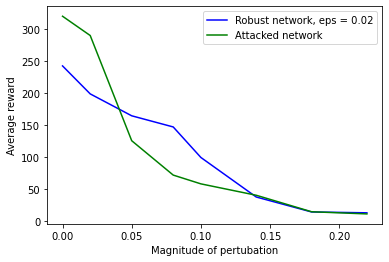

In [64]:
plt.figure(1)
plt.plot(epsilons_attacks,robust_average_rewards[0], "-b",label = "Robust network, eps = 0.02")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

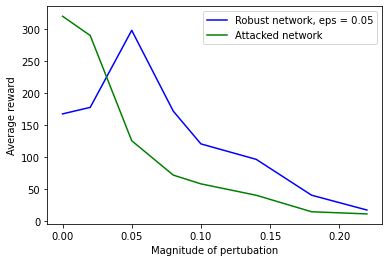

In [65]:
plt.figure(2)
plt.plot(epsilons_attacks,robust_average_rewards[1], "-b",label = "Robust network, eps = 0.05")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

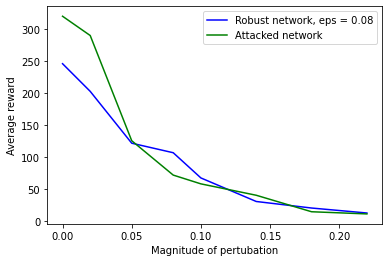

In [66]:
plt.figure(3)
plt.plot(epsilons_attacks,robust_average_rewards[2], "-b",label = "Robust network, eps = 0.08")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

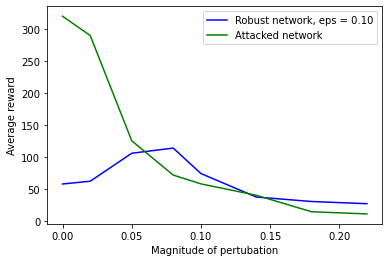

In [67]:
plt.figure(4)
plt.plot(epsilons_attacks,robust_average_rewards[3], "-b",label = "Robust network, eps = 0.10")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()